# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(28,28),self.img.reshape(28,28))

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = 1-ssim(self.X_best.reshape(28,28),self.img.reshape(28,28))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [5]:
model.load_weights('CNN_MNIST.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

# Prepare Data

In [0]:
import pickle
file_ = open('subset', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 100, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


25  :  0.03280457751864546 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


50  :  0.685449807455053 25
75  :  0.6527591506531526 25
100  :  0.7062707852495022 25
125  :  0.7204529091536664 25
150  :  0.7261342501612243 25
175  :  0.7281906072396824 25
200  :  0.7353889171824557 25
225  :  0.739142644781289 25
250  :  0.7412657705597587 25
275  :  0.7412657705597587 25
300  :  0.7412657705597587 25
325  :  0.7412657705597587 25
350  :  0.7412657705597587 25
375  :  0.7412965171660206 25
400  :  0.7543692310580863 25
425  :  0.7543475138556226 25
450  :  0.7542697743769888 25
475  :  0.7542697743769888 25
500  :  0.7542697743769888 25
525  :  0.7558734246270902 25
550  :  0.7558734246270902 25
575  :  0.7559691598197278 25
600  :  0.7566324731886269 25
625  :  0.7566324731886269 25
650  :  0.7566324731886269 25
675  :  0.7573456105472898 25
700  :  0.7573978329687593 25
725  :  0.7581319918585558 25
750  :  0.7586499229226968 25
775  :  0.7586482470034503 25
800  :  0.7586482470034503 25
825  :  0.7588507594575562 25
850  :  0.75929033991857 25
875  :  0.760068

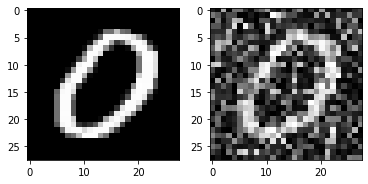

25  :  0.7401084986271484 25
50  :  0.7401084986271484 25
75  :  0.7347881964957474 25
100  :  0.7347881964957474 25
125  :  0.7397710049477683 25
150  :  0.7347881964957474 25
175  :  0.7347881964957474 25
200  :  0.7388571116033176 25
225  :  0.7424762871253451 25
250  :  0.7468013742103061 25
275  :  0.7560143561942871 25
300  :  0.7560143561942871 25
325  :  0.7560143561942871 25
350  :  0.7560143561942871 25
375  :  0.7567392717106021 25
400  :  0.7581340588533215 25
425  :  0.7584363310766843 25
450  :  0.7617838229918545 25
475  :  0.7617187034413678 25
500  :  0.7617187034413678 25
525  :  0.765938023476298 25
550  :  0.7681389545173083 25
575  :  0.7688257169845852 25
600  :  0.7698479281707586 25
625  :  0.7710802686549729 25
650  :  0.7716536272939015 25
675  :  0.7716588317471045 25
700  :  0.7724634795314316 25
725  :  0.7734784741173963 25
750  :  0.7758331365779572 25
775  :  0.7763235187422166 25
800  :  0.7765277865200693 25
Time:  48.17443776130676  seconds
Predicted 

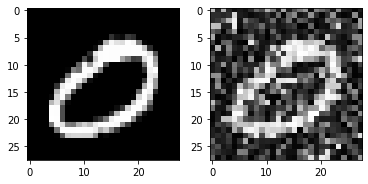

25  :  -0.15658020094179848 25
50  :  -0.11349763684839942 25
75  :  -0.14059695481911738 25
100  :  0.044268729870565515 25
125  :  0.7550093119064323 25
150  :  0.7224783066904751 25
175  :  0.7523223046220269 25
200  :  0.754788388818943 25
225  :  0.754788388818943 25
250  :  0.754788388818943 25
275  :  0.754788388818943 25
300  :  0.754788388818943 25
325  :  0.7597034204146011 25
350  :  0.7587821323523307 25
375  :  0.7603478972118098 25
400  :  0.7603478972118098 25
425  :  0.7603478972118098 25
450  :  0.7604256844569581 25
475  :  0.7702163918062248 25
500  :  0.7702163918062248 25
525  :  0.7703151160175664 25
550  :  0.7702163918062248 25
575  :  0.771436100126655 25
600  :  0.771436100126655 25
625  :  0.771436100126655 25
650  :  0.7720922271759503 25
675  :  0.7744240332706818 25
700  :  0.7743945001526299 25
725  :  0.7746551504322321 25
750  :  0.775923589682946 25
775  :  0.7762758171709875 25
800  :  0.778073271373581 25
825  :  0.778153208290052 25
850  :  0.778279

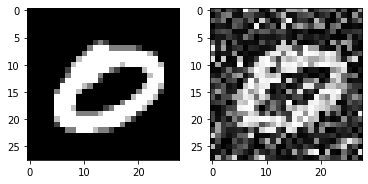

25  :  0.3968248796405173 25
50  :  0.6302345491667392 25
75  :  0.7235982516356667 25
100  :  0.7304651774967295 25
125  :  0.7304651774967295 25
150  :  0.7304651774967295 25
175  :  0.7304651774967295 25
200  :  0.7304651774967295 25
225  :  0.7304651774967295 25
250  :  0.7304651774967295 25
275  :  0.7304651774967295 25
300  :  0.7304651774967295 25
325  :  0.7304651774967295 25
350  :  0.7304651774967295 25
375  :  0.7304651774967295 25
400  :  0.7339381788785437 25
425  :  0.7339381788785437 25
450  :  0.7339381788785437 25
475  :  0.7390575264004036 25
500  :  0.7390418648904054 25
525  :  0.739638700051645 25
550  :  0.7413528061021291 25
575  :  0.743101909841826 25
600  :  0.7420258886320218 25
625  :  0.7426371458827005 25
650  :  0.7481612283949823 25
675  :  0.7482478669517131 25
700  :  0.7482478669517131 25
725  :  0.7493822845290735 25
750  :  0.7493822845290735 25
775  :  0.7519144595598217 25
800  :  0.7526873791005938 25
825  :  0.7544384904141421 25
850  :  0.75528

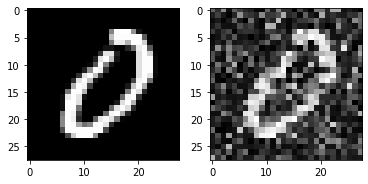

25  :  0.7505597660632155 25
50  :  0.7505597660632155 25
75  :  0.7483569006566682 25
100  :  0.7483569006566682 25
125  :  0.7483569006566682 25
150  :  0.7507251811695712 25
175  :  0.7487141029323966 25
200  :  0.7575004802754125 25
225  :  0.7575004802754125 25
250  :  0.7575004802754125 25
275  :  0.7575004802754125 25
300  :  0.7575004802754125 25
325  :  0.7598143596303939 25
350  :  0.7598143596303939 25
375  :  0.7608186303664367 25
400  :  0.7663487145006547 25
425  :  0.766916093391852 25
450  :  0.7669270330870652 25
475  :  0.7708815038782926 25
500  :  0.7745918791229152 25
525  :  0.775970468520097 25
550  :  0.7760180369436269 25
575  :  0.7760180369436269 25
600  :  0.7760180369436269 25
625  :  0.7760180369436269 25
650  :  0.7768705246661693 25
675  :  0.7772822916791264 25
700  :  0.7783371483402817 25
725  :  0.7783369219658247 25
750  :  0.7783400174362254 25
775  :  0.7789027121905301 25
800  :  0.7790569665375151 25
Time:  48.44032382965088  seconds
Predicted c

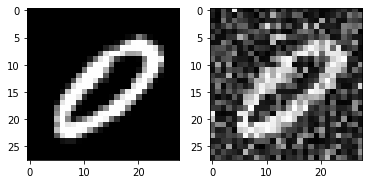

25  :  0.7531355907151822 25
50  :  0.7531355907151822 25
75  :  0.7375234407402019 25
100  :  0.7550781324343139 25
125  :  0.7601647787213555 25
150  :  0.755086387222278 25
175  :  0.755086387222278 25
200  :  0.755086387222278 25
225  :  0.755086387222278 25
250  :  0.755086387222278 25
275  :  0.755086387222278 25
300  :  0.755086387222278 25
325  :  0.755086387222278 25
350  :  0.755086387222278 25
375  :  0.755086387222278 25
400  :  0.755086387222278 25
425  :  0.7573467937777504 25
450  :  0.7596540833667719 25
475  :  0.762799464625055 25
500  :  0.7625455810895734 25
525  :  0.762540127086368 25
550  :  0.7650433986786321 25
575  :  0.7652191772915194 25
600  :  0.7671273641003009 25
625  :  0.7685481320885363 25
650  :  0.7756598220469739 25
675  :  0.7756598220469739 25
700  :  0.7758218363931333 25
725  :  0.7758218363931333 25
750  :  0.7764704377107412 25
775  :  0.7779582291465096 25
800  :  0.7782927292411062 25
825  :  0.7803583716842428 25
850  :  0.7822872534905487

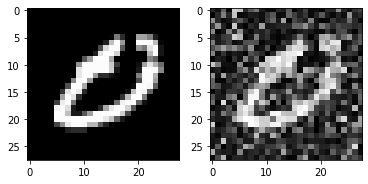

25  :  0.09575950852988652 25
50  :  0.09575950852988652 25
75  :  0.09575950852988652 25
100  :  0.7233101338452537 25
125  :  0.7154689831211877 25
150  :  0.7354676639409556 25
175  :  0.7354676639409556 25
200  :  0.7354676639409556 25
225  :  0.7354676639409556 25
250  :  0.7354676639409556 25
275  :  0.7354676639409556 25
300  :  0.7354676639409556 25
325  :  0.7354676639409556 25
350  :  0.7354676639409556 25
375  :  0.7354676639409556 25
400  :  0.7354676639409556 25
425  :  0.7379008135665567 25
450  :  0.7350996738241521 25
475  :  0.7394973835321079 25
500  :  0.7477620641562759 25
525  :  0.7469332464551279 25
550  :  0.7469332464551279 25
575  :  0.7469332464551279 25
600  :  0.7469332464551279 25
625  :  0.7469332464551279 25
650  :  0.7474590334496256 25
675  :  0.7474590334496256 25
700  :  0.7483146271139103 25
725  :  0.7526207937007564 25
750  :  0.7544402549448136 25
775  :  0.7544137331007821 25
800  :  0.7544137331007821 25
825  :  0.7544137331007821 25
850  :  0.

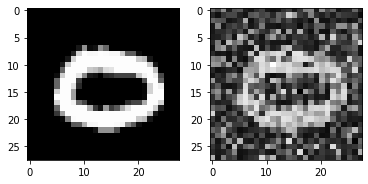

25  :  0.7169846232646759 25
50  :  0.7169846232646759 25
75  :  0.7256704424937099 25
100  :  0.7351861388305734 25
125  :  0.7337884616338496 25
150  :  0.7337884616338496 25
175  :  0.733838874696145 25
200  :  0.7339742832736322 25
225  :  0.7339742832736322 25
250  :  0.7339742832736322 25
275  :  0.7339742832736322 25
300  :  0.7339742832736322 25
325  :  0.7339742832736322 25
350  :  0.7376665048915894 25
375  :  0.7370850834356037 25
400  :  0.7370850834356037 25
425  :  0.740281992153345 25
450  :  0.740281992153345 25
475  :  0.740281992153345 25
500  :  0.740281992153345 25
525  :  0.740281992153345 25
550  :  0.74137018572046 25
575  :  0.7413790525633678 25
600  :  0.7446539929319591 25
625  :  0.7447755351250538 25
650  :  0.7447755351250538 25
675  :  0.745532915790263 25
700  :  0.7465186484702029 25
725  :  0.7494321595934077 25
750  :  0.7494321595934077 25
775  :  0.7494321595934077 25
800  :  0.7494321595934077 25
Time:  49.39606523513794  seconds
Predicted class:  

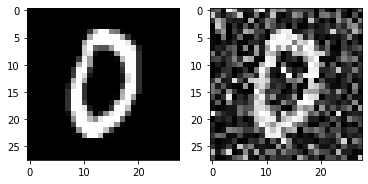

25  :  0.6842198149149032 25
50  :  0.6842198149149032 25
75  :  0.6903727365199425 25
100  :  0.6942152398171693 25
125  :  0.6934732355139446 25
150  :  0.6934732355139446 25
175  :  0.6934732355139446 25
200  :  0.6934732355139446 25
225  :  0.6934732355139446 25
250  :  0.6953598714303926 25
275  :  0.6952557487605541 25
300  :  0.6952557487605541 25
325  :  0.6952557487605541 25
350  :  0.6976670723173917 25
375  :  0.6974619086762199 25
400  :  0.7014508136917177 25
425  :  0.7003372987827123 25
450  :  0.7003372987827123 25
475  :  0.7003372987827123 25
500  :  0.7003372987827123 25
525  :  0.7003372987827123 25
550  :  0.7003372987827123 25
575  :  0.7003372987827123 25
600  :  0.7033346215597777 25
625  :  0.7033346215597777 25
650  :  0.7095792528849587 25
675  :  0.7099628751161313 25
700  :  0.7103201086625547 25
725  :  0.7109624934892468 25
750  :  0.7129386676932805 25
775  :  0.7148728479907457 25
800  :  0.7148570112304417 25
Time:  49.57359838485718  seconds
Predicted

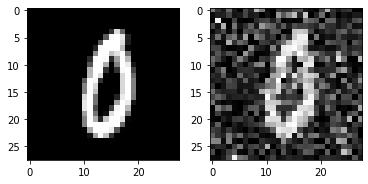

25  :  -0.03712394796011442 25
50  :  0.7082127842601615 25
75  :  0.7211269265728714 25
100  :  0.72043510697908 25
125  :  0.7188101362248156 25
150  :  0.7236405480610993 25
175  :  0.7236405480610993 25
200  :  0.7236405480610993 25
225  :  0.7236405480610993 25
250  :  0.7236405480610993 25
275  :  0.7236405480610993 25
300  :  0.7236405480610993 25
325  :  0.7254899376703345 25
350  :  0.7272644290295506 25
375  :  0.7272644290295506 25
400  :  0.7272644290295506 25
425  :  0.7272644290295506 25
450  :  0.7344506648913562 25
475  :  0.735600920158459 25
500  :  0.735600920158459 25
525  :  0.7361905971131949 25
550  :  0.7402380413500627 25
575  :  0.745996696661455 25
600  :  0.7468598238577117 25
625  :  0.7468598238577117 25
650  :  0.7532068821367515 25
675  :  0.7532068821367515 25
700  :  0.7532068821367515 25
725  :  0.7532068821367515 25
750  :  0.7535323935915605 25
775  :  0.7547935672325639 25
800  :  0.7563399718542152 25
825  :  0.7573940741779415 25
850  :  0.757818

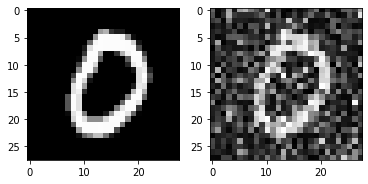

25  :  0.7284692468005934 25
50  :  0.7722136820340982 25
75  :  0.772979748708173 25
100  :  0.7722136820340982 25
125  :  0.7722136820340982 25
150  :  0.7728546941363283 25
175  :  0.7782868115490156 25
200  :  0.7777457593818157 25
225  :  0.7830833355480694 25
250  :  0.7830833355480694 25
275  :  0.7839880875376963 25
300  :  0.7839880875376963 25
325  :  0.7839880875376963 25
350  :  0.7841624521031676 25
375  :  0.7841624521031676 25
400  :  0.786504500725641 25
425  :  0.787399884737194 25
450  :  0.7896594761627427 25
475  :  0.7896399923744637 25
500  :  0.7896623352162262 25
525  :  0.7930091250597241 25
550  :  0.7946348233528169 25
575  :  0.7946348233528169 25
600  :  0.7946348233528169 25
625  :  0.796559583096442 25
650  :  0.798311755938266 25
675  :  0.7983192887560928 25
700  :  0.7986290948904522 25
725  :  0.7995765935145053 25
750  :  0.7996613793761222 25
775  :  0.7999637643958067 25
800  :  0.8009282970819838 25
825  :  0.8016391001753705 25
Time:  50.51138758

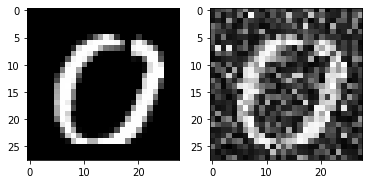

25  :  0.23701845265098398 25
50  :  0.7284597361081814 25
75  :  0.7267824405660837 25
100  :  0.7181924195794627 25
125  :  0.7337952524904578 25
150  :  0.7236842550621929 25
175  :  0.7444635673676595 25
200  :  0.750557059466993 25
225  :  0.750557059466993 25
250  :  0.750557059466993 25
275  :  0.750557059466993 25
300  :  0.750557059466993 25
325  :  0.750557059466993 25
350  :  0.750557059466993 25
375  :  0.750557059466993 25
400  :  0.7567239439479347 25
425  :  0.7575612252701096 25
450  :  0.7579033341908622 25
475  :  0.757637908544432 25
500  :  0.7603912378028574 25
525  :  0.7648213751677089 25
550  :  0.7667055724957634 25
575  :  0.7666928375388344 25
600  :  0.7712079533530936 25
625  :  0.7712079084997765 25
650  :  0.7746950301949478 25
675  :  0.77446896264646 25
700  :  0.7759400483615523 25
725  :  0.7772240503660018 25
750  :  0.7796361159167022 25
775  :  0.7808660250611539 25
800  :  0.7808659636428918 25
825  :  0.7818396372498835 25
850  :  0.7827626557199

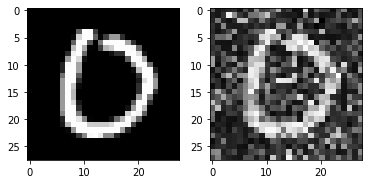

25  :  0.7736955080586199 25
50  :  0.7736955080586199 25
75  :  0.7773503500392369 25
100  :  0.7945238499648297 25
125  :  0.7942530469648312 25
150  :  0.7992991512675742 25
175  :  0.799141861940128 25
200  :  0.8023419180107539 25
225  :  0.8018804673952313 25
250  :  0.803243426184315 25
275  :  0.803243426184315 25
300  :  0.8053874098684235 25
325  :  0.8091867971403622 25
350  :  0.8099038424199352 25
375  :  0.8098586293722271 25
400  :  0.8098586293722271 25
425  :  0.8114126898656777 25
450  :  0.8134597199682629 25
475  :  0.8141120633512999 25
500  :  0.8153820320348049 25
525  :  0.8155949129282158 25
550  :  0.8155949129282158 25
575  :  0.8166859965053477 25
600  :  0.8170232191896175 25
625  :  0.8176799077119977 25
650  :  0.8192096651091387 25
675  :  0.8192096651091387 25
700  :  0.8198934848133672 25
725  :  0.8207869814702173 25
750  :  0.8207869814702173 25
775  :  0.8215902110561798 25
800  :  0.8218607020595197 25
825  :  0.8219869137771967 25
850  :  0.822195

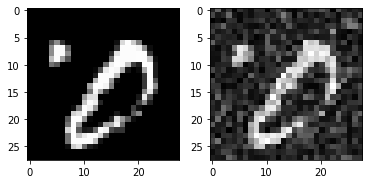

25  :  0.6324591693455854 25
50  :  0.6324591693455854 25
75  :  0.6324591693455854 25
100  :  0.6381341461236875 25
125  :  0.6381341461236875 25
150  :  0.6381341461236875 25
175  :  0.6381341461236875 25
200  :  0.6381341461236875 25
225  :  0.6381341461236875 25
250  :  0.639877760387406 25
275  :  0.6411074538346195 25
300  :  0.6411074538346195 25
325  :  0.6411074538346195 25
350  :  0.6411412192235983 25
375  :  0.6411412192235983 25
400  :  0.6411412192235983 25
425  :  0.6417272331506976 25
450  :  0.6430548464476712 25
475  :  0.6452367233667163 25
500  :  0.6449957640291899 25
525  :  0.6449957640291899 25
550  :  0.6449957640291899 25
575  :  0.6449957640291899 25
600  :  0.6449957640291899 25
625  :  0.6449957640291899 25
650  :  0.6452980850737369 25
675  :  0.646473406925852 25
700  :  0.6476380833147956 25
725  :  0.6476380833147956 25
750  :  0.647882104506304 25
775  :  0.6484205934468127 25
800  :  0.6484065377026602 25
Time:  49.10088062286377  seconds
Predicted cl

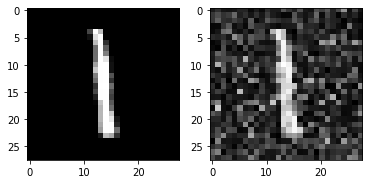

25  :  0.6361101549896824 25
50  :  0.6361101549896824 25
75  :  0.6405115426187159 25
100  :  0.6403283609784948 25
125  :  0.6403283609784948 25
150  :  0.6416899950074354 25
175  :  0.6403283609784948 25
200  :  0.6403283609784948 25
225  :  0.6403283609784948 25
250  :  0.6403283609784948 25
275  :  0.6423372022580416 25
300  :  0.6412092445030954 25
325  :  0.6439293889856463 25
350  :  0.6439526291601201 25
375  :  0.6439234878341642 25
400  :  0.6439234878341642 25
425  :  0.6450552819910931 25
450  :  0.6452712790318708 25
475  :  0.6452712790318708 25
500  :  0.6456223184786056 25
525  :  0.6457131397561175 25
550  :  0.6457131397561175 25
575  :  0.6467698377730693 25
600  :  0.6467997876795819 25
625  :  0.6467997876795819 25
650  :  0.6472093925340688 25
675  :  0.6471580952026083 25
700  :  0.6475846644460534 25
725  :  0.6488368725429733 25
750  :  0.6488160719655487 25
775  :  0.6488160719655487 25
800  :  0.6492760985516962 25
Time:  49.02533745765686  seconds
Predicted

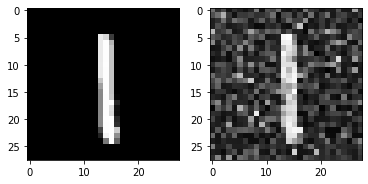

25  :  0.5924890747386485 25
50  :  0.5949497946335327 25
75  :  0.5989732673722048 25
100  :  0.5973380503312231 25
125  :  0.5958420748970663 25
150  :  0.5998887639379298 25
175  :  0.6000868755459259 25
200  :  0.6017944881363337 25
225  :  0.6009230178601718 25
250  :  0.6010857753731855 25
275  :  0.6009230178601718 25
300  :  0.6011259308038547 25
325  :  0.6013572465614765 25
350  :  0.6013572465614765 25
375  :  0.6013572465614765 25
400  :  0.6013572465614765 25
425  :  0.6015867263487528 25
450  :  0.6017086277558938 25
475  :  0.6027125057176357 25
500  :  0.6035239323007999 25
525  :  0.604514727462418 25
550  :  0.60546738631485 25
575  :  0.6060280812331443 25
600  :  0.6078801972221771 25
625  :  0.6078037889553201 25
650  :  0.6089578235832149 25
675  :  0.6086462161237378 25
700  :  0.6094696440695215 25
725  :  0.6108523257360733 25
750  :  0.6110515043741139 25
775  :  0.6132597901147896 25
800  :  0.6127242394314816 25
Time:  49.62988615036011  seconds
Predicted cl

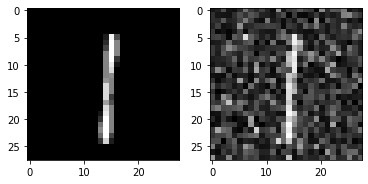

25  :  0.6330121908108391 25
50  :  0.6330121908108391 25
75  :  0.6330121908108391 25
100  :  0.6330515183403183 25
125  :  0.6330121908108391 25
150  :  0.6330121908108391 25
175  :  0.6330121908108391 25
200  :  0.6336452395839849 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


225  :  0.6343760172292805 25
250  :  0.633435720295707 25
275  :  0.633435720295707 25
300  :  0.6383113950591601 25
325  :  0.6382062659761861 25
350  :  0.6382062659761861 25
375  :  0.6382062659761861 25
400  :  0.6382062659761861 25
425  :  0.6382062659761861 25
450  :  0.6382062659761861 25
475  :  0.6390155552332739 25
500  :  0.641788688004533 25
525  :  0.6427185576647723 25
550  :  0.6459513146607939 25
575  :  0.6404139966238652 25
600  :  0.6408169169099261 25
625  :  0.640972279672819 25
650  :  0.6413367206657646 25
675  :  0.6417347597505887 25
700  :  0.6413359106541038 25
725  :  0.6437660778580395 25
750  :  0.6459962173072415 25
775  :  0.6459321325687738 25
800  :  0.6459321325687738 25
Time:  48.02727007865906  seconds
Predicted class:  [8]


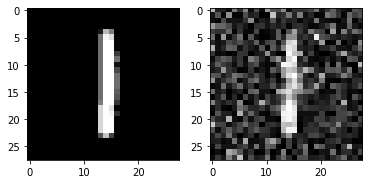

25  :  0.6643585987984411 25
50  :  0.665387094803831 25
75  :  0.6690025465047809 25
100  :  0.6690025465047809 25
125  :  0.6690025465047809 25
150  :  0.6690025465047809 25
175  :  0.6693642236378603 25
200  :  0.6724377875906195 25
225  :  0.6723040683007024 25
250  :  0.6723040683007024 25
275  :  0.6757058164725814 25
300  :  0.6744763038651951 25
325  :  0.6747397960146302 25
350  :  0.6745337873446581 25
375  :  0.6745337873446581 25
400  :  0.6745337873446581 25
425  :  0.6774870179408841 25
450  :  0.6774870179408841 25
475  :  0.6774870179408841 25
500  :  0.6774870179408841 25
525  :  0.6781422122419638 25
550  :  0.6781422122419638 25
575  :  0.6781422122419638 25
600  :  0.6781422122419638 25
625  :  0.6781422122419638 25
650  :  0.6781422122419638 25
675  :  0.6781422122419638 25
700  :  0.6781422122419638 25
725  :  0.6785167264560645 25
750  :  0.6785167264560645 25
775  :  0.6786935294295207 25
800  :  0.6786935294295207 25
Time:  45.682435274124146  seconds
Predicted

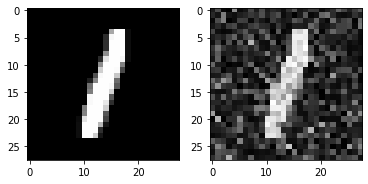

25  :  0.6627390119934968 25
50  :  0.6627390119934968 25
75  :  0.6627390119934968 25
100  :  0.6627390119934968 25
125  :  0.6627390119934968 25
150  :  0.6648396863094206 25
175  :  0.6648396863094206 25
200  :  0.6648396863094206 25
225  :  0.6648396863094206 25
250  :  0.6648396863094206 25
275  :  0.6663347459812979 25
300  :  0.6663347459812979 25
325  :  0.6663347459812979 25
350  :  0.6676633043130263 25
375  :  0.6677159108357177 25
400  :  0.6697787246400673 25
425  :  0.6697787246400673 25
450  :  0.6697787246400673 25
475  :  0.6698883909069968 25
500  :  0.6698800254634976 25
525  :  0.6698800254634976 25
550  :  0.6702524743047139 25
575  :  0.6728257941507086 25
600  :  0.6728301730426446 25
625  :  0.6735543377430494 25
650  :  0.6743083949341673 25
675  :  0.6741942105682992 25
700  :  0.6743163351961814 25
725  :  0.6743192303723983 25
750  :  0.6743359452263767 25
775  :  0.6743359452263767 25
800  :  0.6748351977726819 25
Time:  44.84093904495239  seconds
Predicted

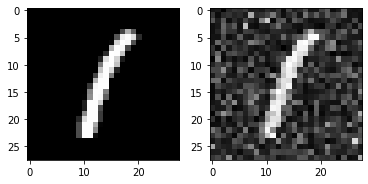

25  :  0.644123981519872 25
50  :  0.644123981519872 25
75  :  0.6402943766029875 25
100  :  0.6402943766029875 25
125  :  0.6402943766029875 25
150  :  0.6402943766029875 25
175  :  0.6500943647249894 25
200  :  0.6500943647249894 25
225  :  0.6500943647249894 25
250  :  0.6500943647249894 25
275  :  0.6500943647249894 25
300  :  0.6500943647249894 25
325  :  0.6500943647249894 25
350  :  0.6500943647249894 25
375  :  0.6500943647249894 25
400  :  0.6516122231280626 25
425  :  0.6516122231280626 25
450  :  0.6521965077458447 25
475  :  0.6526202371853855 25
500  :  0.6547616678269709 25
525  :  0.6550567008410091 25
550  :  0.6550567008410091 25
575  :  0.6550567008410091 25
600  :  0.6550567008410091 25
625  :  0.6557476663904549 25
650  :  0.6560808858472578 25
675  :  0.6585760703673464 25
700  :  0.6582913597286582 25
725  :  0.6586866889656116 25
750  :  0.65861915056067 25
775  :  0.6597232656072396 25
800  :  0.6596194100875937 25
Time:  45.170782804489136  seconds
Predicted cl

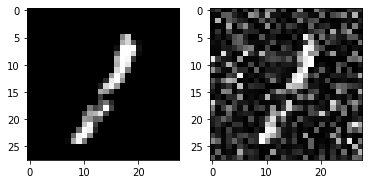

25  :  0.6360370152333232 25
50  :  0.6360370152333232 25
75  :  0.6380041490465689 25
100  :  0.6388145734446513 25
125  :  0.6393963992584386 25
150  :  0.6393963992584386 25
175  :  0.6397363893079555 25
200  :  0.6445384266707789 25
225  :  0.6456025029397758 25
250  :  0.6457155918671107 25
275  :  0.6455194422605388 25
300  :  0.6460029608734583 25
325  :  0.6461036423004234 25
350  :  0.6476488453782937 25
375  :  0.6482448186537029 25
400  :  0.6481767465855477 25
425  :  0.6488371090798768 25
450  :  0.6492783266853734 25
475  :  0.6492722549942296 25
500  :  0.6492722549942296 25
525  :  0.6502871656600654 25
550  :  0.6502074827750951 25
575  :  0.6502907377823678 25
600  :  0.6518242052713027 25
625  :  0.6518237132043966 25
650  :  0.6518237132043966 25
675  :  0.6520608469278847 25
700  :  0.6531690564863684 25
725  :  0.6531809935521267 25
750  :  0.6545277875804405 25
775  :  0.6555809522345738 25
800  :  0.6556773453524483 25
Time:  45.39899206161499  seconds
Predicted

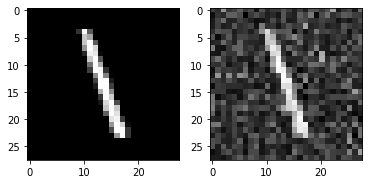

25  :  0.6478349261735784 25
50  :  0.6530392129045692 25
75  :  0.6500543180183507 25
100  :  0.6500543180183507 25
125  :  0.6500543180183507 25
150  :  0.6500543180183507 25
175  :  0.6534614884962358 25
200  :  0.6544338036385712 25
225  :  0.654977305926875 25
250  :  0.6576394911092897 25
275  :  0.6555817629202966 25
300  :  0.6569977667462037 25
325  :  0.6580502508393467 25
350  :  0.6588120141806102 25
375  :  0.6581037803312744 25
400  :  0.6581037803312744 25
425  :  0.6581037803312744 25
450  :  0.6581037803312744 25
475  :  0.6581037803312744 25
500  :  0.6605176665715159 25
525  :  0.6605176665715159 25
550  :  0.6605176665715159 25
575  :  0.6605176665715159 25
600  :  0.6616771502100001 25
625  :  0.6621462469541011 25
650  :  0.6621080856356238 25
675  :  0.6621080856356238 25
700  :  0.6621080856356238 25
725  :  0.6621080856356238 25
750  :  0.6621080856356238 25
775  :  0.6621080856356238 25
800  :  0.6621080856356238 25
Time:  44.53970146179199  seconds
Predicted 

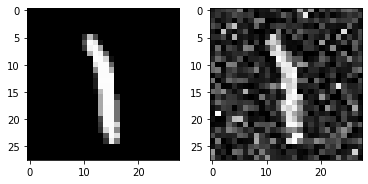

25  :  0.6156122239390371 25
50  :  0.6157803266190803 25
75  :  0.6184357524412052 25
100  :  0.622936654533477 25
125  :  0.6242524142961525 25
150  :  0.6242524142961525 25
175  :  0.6274200793884942 25
200  :  0.6302402941655684 25
225  :  0.6285674285934707 25
250  :  0.6285674285934707 25
275  :  0.629366957338063 25
300  :  0.62882785495234 25
325  :  0.62882785495234 25
350  :  0.62882785495234 25
375  :  0.6301561990589969 25
400  :  0.6344693060216462 25
425  :  0.6329954537510227 25
450  :  0.6330198315009662 25
475  :  0.6332682925298194 25
500  :  0.6332682925298194 25
525  :  0.6332682925298194 25
550  :  0.6332682925298194 25
575  :  0.6349081010776128 25
600  :  0.6351315500499961 25
625  :  0.6351315500499961 25
650  :  0.6360046244769569 25
675  :  0.6365579471563954 25
700  :  0.6373947067331613 25
725  :  0.637924919182333 25
750  :  0.638073445332507 25
775  :  0.6380898880188505 25
800  :  0.638540456679502 25
Time:  45.421873331069946  seconds
Predicted class:  [

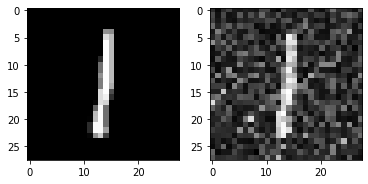

25  :  0.6487336958667742 25
50  :  0.6487336958667742 25
75  :  0.6487764927988199 25
100  :  0.6488232301205075 25
125  :  0.6488232301205075 25
150  :  0.6488232301205075 25
175  :  0.6522428247597554 25
200  :  0.6524155532480462 25
225  :  0.6524155532480462 25
250  :  0.6524155532480462 25
275  :  0.6535474788380558 25
300  :  0.6502873498492716 25
325  :  0.6524037634108573 25
350  :  0.6520702991127186 25
375  :  0.6520702991127186 25
400  :  0.6524191763407506 25
425  :  0.6527743273029695 25
450  :  0.6524643356455544 25
475  :  0.6558204937570657 25
500  :  0.6555872946715288 25
525  :  0.6588005807652024 25
550  :  0.658083745726216 25
575  :  0.658083745726216 25
600  :  0.658083745726216 25
625  :  0.658083745726216 25
650  :  0.6584040910058455 25
675  :  0.6586115339019895 25
700  :  0.6588444097765884 25
725  :  0.6588444097765884 25
750  :  0.6588444097765884 25
775  :  0.6590000945640726 25
800  :  0.6588444097765884 25
Time:  44.60005784034729  seconds
Predicted cla

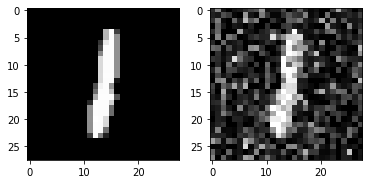

25  :  0.6215592538155118 25
50  :  0.6218496487231969 25
75  :  0.6210654351169744 25
100  :  0.6256720766296425 25
125  :  0.6224115740362315 25
150  :  0.6272014703596045 25
175  :  0.6269077935444869 25
200  :  0.6306636235397989 25
225  :  0.6297507968121476 25
250  :  0.6317666506284061 25
275  :  0.6316304954022919 25
300  :  0.6318019949032729 25
325  :  0.6337725275469452 25
350  :  0.6346985722768202 25
375  :  0.6339218293229656 25
400  :  0.6339218293229656 25
425  :  0.6339218293229656 25
450  :  0.6374476598706964 25
475  :  0.6374423113270301 25
500  :  0.6395510664693658 25
525  :  0.6399600670030919 25
550  :  0.6399600670030919 25
575  :  0.6399600670030919 25
600  :  0.6399600670030919 25
625  :  0.6399600670030919 25
650  :  0.6406937976576792 25
675  :  0.6409103012394395 25
700  :  0.64228340167736 25
725  :  0.64228340167736 25
750  :  0.64228340167736 25
775  :  0.6427570222796519 25
800  :  0.642879426720988 25
Time:  44.565661668777466  seconds
Predicted class

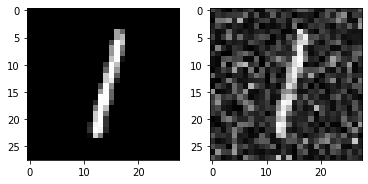

25  :  0.6473487550970808 25
50  :  0.6473487550970808 25
75  :  0.6473487550970808 25
100  :  0.6473487550970808 25
125  :  0.6482127199871227 25
150  :  0.6482127199871227 25
175  :  0.6530000901101632 25
200  :  0.6504333131820589 25
225  :  0.6504333131820589 25
250  :  0.6504333131820589 25
275  :  0.6504333131820589 25
300  :  0.6507521105680727 25
325  :  0.6509074878618353 25
350  :  0.6509074878618353 25
375  :  0.6509074878618353 25
400  :  0.6509074878618353 25
425  :  0.6521561234077511 25
450  :  0.6515160826710304 25
475  :  0.6542985036052845 25
500  :  0.6548774694532347 25
525  :  0.6552970410380384 25
550  :  0.6570842100359755 25
575  :  0.6570842100359755 25
600  :  0.6570842100359755 25
625  :  0.6570842100359755 25
650  :  0.6570842100359755 25
675  :  0.6570842100359755 25
700  :  0.6570842100359755 25
725  :  0.6570842100359755 25
750  :  0.6570842100359755 25
775  :  0.6575465873150157 25
800  :  0.6580539947436652 25
Time:  44.30660367012024  seconds
Predicted

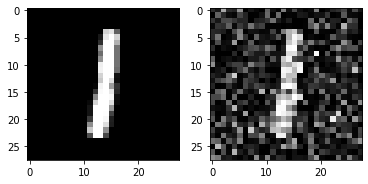

25  :  0.6529750536284671 25
50  :  0.6529750536284671 25
75  :  0.6526542577943152 25
100  :  0.6570926097386351 25
125  :  0.6590087438699084 25
150  :  0.6654708636305414 25
175  :  0.6654708636305414 25
200  :  0.6654708636305414 25
225  :  0.6654708636305414 25
250  :  0.6684515130909964 25
275  :  0.668983624168104 25
300  :  0.668983624168104 25
325  :  0.6697850289797351 25
350  :  0.6720315398049375 25
375  :  0.6720315398049375 25
400  :  0.6720315398049375 25
425  :  0.6730985200095494 25
450  :  0.6730981788919841 25
475  :  0.6730981788919841 25
500  :  0.6742113476638845 25
525  :  0.6748288865158188 25
550  :  0.6748379735984984 25
575  :  0.6748379735984984 25
600  :  0.6748805564121038 25
625  :  0.6753242367572705 25
650  :  0.6753242367572705 25
675  :  0.6759900722501597 25
700  :  0.676318853959313 25
725  :  0.676318853959313 25
750  :  0.6763614849066361 25
775  :  0.6766363557235644 25
800  :  0.6768833337386873 25
Time:  44.56516671180725  seconds
Predicted cla

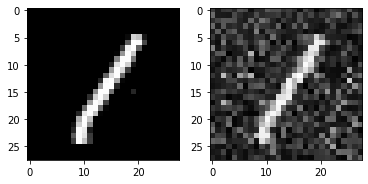

25  :  0.6642580853038405 25
50  :  0.6642580853038405 25
75  :  0.6737158927977848 25
100  :  0.6737158927977848 25
125  :  0.6737158927977848 25
150  :  0.6737158927977848 25
175  :  0.6783989875710335 25
200  :  0.6775524300966868 25
225  :  0.6775524300966868 25
250  :  0.6775524300966868 25
275  :  0.6775524300966868 25
300  :  0.6775524300966868 25
325  :  0.6775524300966868 25
350  :  0.6825566444566702 25
375  :  0.6825566444566702 25
400  :  0.6825566444566702 25
425  :  0.6837845300837642 25
450  :  0.6837845300837642 25
475  :  0.684722085683279 25
500  :  0.6846979683058625 25
525  :  0.6846362257031603 25
550  :  0.6853617949398263 25
575  :  0.6854613667484417 25
600  :  0.6869247476461714 25
625  :  0.6868097939221943 25
650  :  0.6868097939221943 25
675  :  0.6870633321047107 25
700  :  0.6871745409435431 25
725  :  0.6871685551184787 25
750  :  0.6871685551184787 25
775  :  0.6871685551184787 25
800  :  0.6874069537335754 25
Time:  45.039820194244385  seconds
Predicted

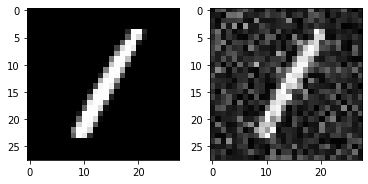

25  :  -0.1909294552657546 25
50  :  -0.18879628690223915 25
75  :  -0.1833415904593299 25
100  :  -0.17332888828564347 25
125  :  -0.17000658825947573 25
150  :  -0.16962474648977577 25
175  :  -0.16639727656597708 25
200  :  -0.16639727656597708 25
225  :  -0.16184283142044892 25
250  :  -0.16184283142044892 25
275  :  -0.15827999977466073 25
300  :  -0.15827999977466073 25
325  :  -0.15827999977466073 25
350  :  -0.15424432722861775 25
375  :  -0.15424432722861775 25
400  :  -0.15410140010774304 25
425  :  -0.15337844720060478 25
450  :  -0.15303374812770942 25
475  :  -0.15303374812770942 25
500  :  -0.15258973682931004 25
525  :  -0.15009922744880333 25
550  :  -0.14916937767016547 25
575  :  -0.14916937767016547 25
600  :  -0.14916937767016547 25
625  :  -0.14748380867076388 25
650  :  -0.14748385996288865 25
675  :  -0.14702647738848718 25
700  :  -0.14670827698771383 25
725  :  -0.14627547070346886 25
750  :  -0.1460254056536821 25
775  :  -0.14599042175344734 25
800  :  -0.145

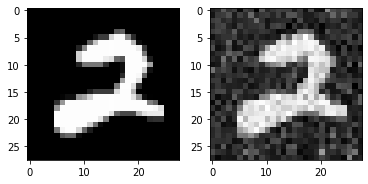

25  :  -0.06486044767231552 25
50  :  0.17877871303256737 25
75  :  0.7236059949127971 25
100  :  0.7191584116711005 25
125  :  0.7236127716634013 25
150  :  0.7296404759007408 25
175  :  0.7342984946862737 25
200  :  0.7342984946862737 25
225  :  0.7342984946862737 25
250  :  0.7342984946862737 25
275  :  0.7342984946862737 25
300  :  0.7342984946862737 25
325  :  0.7342984946862737 25
350  :  0.7342984946862737 25
375  :  0.7342984946862737 25
400  :  0.7351001594433748 25
425  :  0.7374257783628287 25
450  :  0.7374257783628287 25
475  :  0.7386744648303721 25
500  :  0.7407584192071435 25
525  :  0.7407584192071435 25
550  :  0.7415920357997754 25
575  :  0.7415407480168812 25
600  :  0.7421253917558914 25
625  :  0.7421253917558914 25
650  :  0.7438166518450738 25
675  :  0.7450223778704848 25
700  :  0.7450972625378818 25
725  :  0.746936736077672 25
750  :  0.7469323572615306 25
775  :  0.7482630075023018 25
800  :  0.7489291740838222 25
825  :  0.7496853992509218 25
850  :  0.7

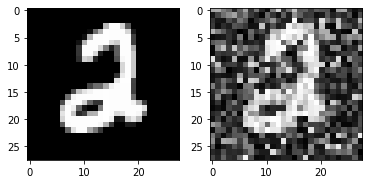

25  :  0.44132882704958587 25
50  :  0.6713859456385699 25
75  :  0.6094597794657614 25
100  :  0.6310933710322675 25
125  :  0.7144533754647464 25
150  :  0.7046729978240724 25
175  :  0.7046729978240724 25
200  :  0.7046729978240724 25
225  :  0.7046729978240724 25
250  :  0.7046729978240724 25
275  :  0.7046729978240724 25
300  :  0.7046729978240724 25
325  :  0.7046729978240724 25
350  :  0.7046729978240724 25
375  :  0.7046729978240724 25
400  :  0.708245931557804 25
425  :  0.7113442475225189 25
450  :  0.7113442475225189 25
475  :  0.7162902048391384 25
500  :  0.7156064650004865 25
525  :  0.7185284346046733 25
550  :  0.7185284346046733 25
575  :  0.7220123341342746 25
600  :  0.7227179094100062 25
625  :  0.7224450751546884 25
650  :  0.7224450751546884 25
675  :  0.7224450751546884 25
700  :  0.7235701708214446 25
725  :  0.7235701708214446 25
750  :  0.7249461688379177 25
775  :  0.7250734191467484 25
800  :  0.7261354335628762 25
825  :  0.7290550730415224 25
850  :  0.729

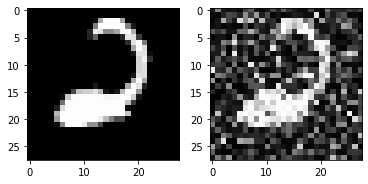

25  :  0.7159897859805717 25
50  :  0.7159897859805717 25
75  :  0.7159897859805717 25
100  :  0.7159897859805717 25
125  :  0.7159897859805717 25
150  :  0.7159897859805717 25
175  :  0.715996126310279 25
200  :  0.7166316387710854 25
225  :  0.7166703186803819 25
250  :  0.7170212952470827 25
275  :  0.7214105415455023 25
300  :  0.7235520904823358 25
325  :  0.7222130711377595 25
350  :  0.7222130711377595 25
375  :  0.7236967069953018 25
400  :  0.7237143744894081 25
425  :  0.7238873566803798 25
450  :  0.7244807930046477 25
475  :  0.7246445308649938 25
500  :  0.7276324281058646 25
525  :  0.7282758332167141 25
550  :  0.7282917180297406 25
575  :  0.7291719068674116 25
600  :  0.7325313348935578 25
625  :  0.73331858741548 25
650  :  0.7333548834588763 25
675  :  0.7370241082253193 25
700  :  0.7384699172041762 25
725  :  0.7393876907389358 25
750  :  0.7393895235369905 25
775  :  0.7393895235369905 25
800  :  0.7398058378263621 25
Time:  44.52582669258118  seconds
Predicted cl

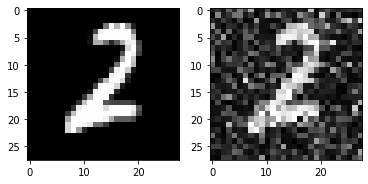

25  :  0.5614604927096353 25
50  :  0.6861444308617936 25
75  :  0.7183183268264024 25
100  :  0.7183183268264024 25
125  :  0.7183183268264024 25
150  :  0.7331032297396216 25
175  :  0.7331032297396216 25
200  :  0.7331032297396216 25
225  :  0.7331032297396216 25
250  :  0.7331032297396216 25
275  :  0.7362636468822708 25
300  :  0.7362636468822708 25
325  :  0.7365425107973624 25
350  :  0.73704909907804 25
375  :  0.73746123240665 25
400  :  0.7363384464253506 25
425  :  0.7412314851770996 25
450  :  0.741224754757509 25
475  :  0.741224754757509 25
500  :  0.741224754757509 25
525  :  0.7471875603406289 25
550  :  0.7473081611539021 25
575  :  0.7473081611539021 25
600  :  0.7473081611539021 25
625  :  0.7483018940626293 25
650  :  0.7483018940626293 25
675  :  0.7488871706423796 25
700  :  0.7494843661411112 25
725  :  0.7500540835247722 25
750  :  0.7515042545784814 25
775  :  0.7514854201470504 25
800  :  0.7534445918030268 25
825  :  0.7535192996109671 25
850  :  0.7544368728

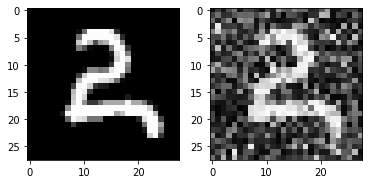

25  :  0.6912096545269124 25
50  :  0.7059959550357977 25
75  :  0.7192365832789253 25
100  :  0.7192365832789253 25
125  :  0.7192365832789253 25
150  :  0.7192365832789253 25
175  :  0.7192365832789253 25
200  :  0.7213716456823805 25
225  :  0.7213716456823805 25
250  :  0.7218962550723671 25
275  :  0.7224971467416489 25
300  :  0.7266970011200329 25
325  :  0.7266970011200329 25
350  :  0.7266970011200329 25
375  :  0.7281879152019798 25
400  :  0.7310115903588726 25
425  :  0.7310115903588726 25
450  :  0.7365249820031555 25
475  :  0.7374211198265672 25
500  :  0.7384453797446012 25
525  :  0.7399773723950731 25
550  :  0.7399773723950731 25
575  :  0.7437052082314582 25
600  :  0.7462656955776006 25
625  :  0.7462670745058082 25
650  :  0.7462670745058082 25
675  :  0.7479617264682049 25
700  :  0.7491862387110408 25
725  :  0.7504792967002275 25
750  :  0.7523558935895975 25
775  :  0.7539831428106418 25
800  :  0.7539831428106418 25
825  :  0.7552937239183259 25
850  :  0.755

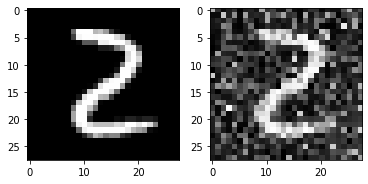

25  :  0.7295642745635499 25
50  :  0.7545529618719818 25
75  :  0.7703198603276311 25
100  :  0.7594282880862361 25
125  :  0.7653027430963121 25
150  :  0.7657268611164818 25
175  :  0.7783926120328192 25
200  :  0.7787069805025039 25
225  :  0.7787069805025039 25
250  :  0.7787069805025039 25
275  :  0.7787069805025039 25
300  :  0.7787069805025039 25
325  :  0.7814528462704233 25
350  :  0.7814528462704233 25
375  :  0.7891809574738753 25
400  :  0.7891809574738753 25
425  :  0.7891809574738753 25
450  :  0.7904755748564257 25
475  :  0.7917025771988546 25
500  :  0.7916138561224251 25
525  :  0.7916138561224251 25
550  :  0.7916138561224251 25
575  :  0.7940079162770104 25
600  :  0.7951116838518419 25
625  :  0.7950498433555483 25
650  :  0.7950498433555483 25
675  :  0.7950498433555483 25
700  :  0.7961108183372336 25
725  :  0.7967072417673328 25
750  :  0.7971532609553593 25
775  :  0.7973125509488028 25
800  :  0.7976156504566105 25
825  :  0.7987527214187324 25
850  :  0.798

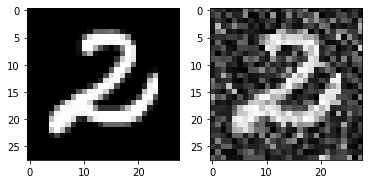

25  :  0.649906454199914 25
50  :  0.7176141890773199 25
75  :  0.7074682290199656 25
100  :  0.7251610918543163 25
125  :  0.7138655587108887 25
150  :  0.7182261057345534 25
175  :  0.7188764177691831 25
200  :  0.7239097248006227 25
225  :  0.7219751258271343 25
250  :  0.7219751258271343 25
275  :  0.72431254326414 25
300  :  0.7223752916456625 25
325  :  0.7222014486836745 25
350  :  0.7265131821008975 25
375  :  0.7259457078314738 25
400  :  0.7333966357533235 25
425  :  0.7337650186829218 25
450  :  0.7337650186829218 25
475  :  0.7337650186829218 25
500  :  0.7337650186829218 25
525  :  0.7363173529984945 25
550  :  0.7363173529984945 25
575  :  0.7363173529984945 25
600  :  0.7363173529984945 25
625  :  0.7364391152768491 25
650  :  0.7364391152768491 25
675  :  0.7390710298407964 25
700  :  0.7390710298407964 25
725  :  0.7390710298407964 25
750  :  0.7409888691751815 25
775  :  0.7409888691751815 25
800  :  0.7409888691751815 25
825  :  0.741932377340335 25
850  :  0.7426379

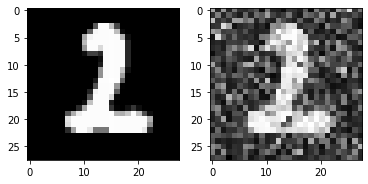

25  :  0.6066325551088629 25
50  :  0.6123554707951631 25
75  :  0.6825233666080083 25
100  :  0.6898336583983529 25
125  :  0.7028453880398837 25
150  :  0.7037738069783301 25
175  :  0.7037738069783301 25
200  :  0.7037738069783301 25
225  :  0.7037738069783301 25
250  :  0.7042984706635257 25
275  :  0.7037738069783301 25
300  :  0.7092382543532599 25
325  :  0.7094098961622712 25
350  :  0.713528719552766 25
375  :  0.718253695495338 25
400  :  0.718253695495338 25
425  :  0.7183886111108138 25
450  :  0.7209561064521175 25
475  :  0.7213486344821293 25
500  :  0.7213486344821293 25
525  :  0.7216410390649698 25
550  :  0.7237510209196527 25
575  :  0.7242415502803218 25
600  :  0.7243620628288496 25
625  :  0.7252785921109415 25
650  :  0.7260429180171497 25
675  :  0.7260907273986416 25
700  :  0.726073358521369 25
725  :  0.7261575902162815 25
750  :  0.7262397691670555 25
775  :  0.7263623592458759 25
800  :  0.7263594816867331 25
825  :  0.7264522062238185 25
850  :  0.7264686

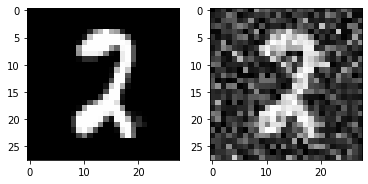

25  :  0.6673100894318219 25
50  :  0.6673290094580302 25
75  :  0.6990861902257831 25
100  :  0.6996835770991479 25
125  :  0.6996835770991479 25
150  :  0.7028232546727776 25
175  :  0.7011907468167121 25
200  :  0.7011907468167121 25
225  :  0.7015438619952058 25
250  :  0.7041832598657848 25
275  :  0.7023659883055742 25
300  :  0.7023659883055742 25
325  :  0.7084423754883842 25
350  :  0.7166640656580496 25
375  :  0.71185070984747 25
400  :  0.71185070984747 25
425  :  0.7197835944141359 25
450  :  0.7193008194870849 25
475  :  0.7207772813150031 25
500  :  0.7206170785002995 25
525  :  0.722548665975183 25
550  :  0.7226640134527234 25
575  :  0.7226640134527234 25
600  :  0.7232601492612899 25
625  :  0.7254846104119843 25
650  :  0.7260149068367165 25
675  :  0.7263256813611092 25
700  :  0.7263256813611092 25
725  :  0.7263256813611092 25
750  :  0.7273199180749266 25
775  :  0.7273197751626216 25
800  :  0.7273197751626216 25
825  :  0.7274749736854143 25
850  :  0.72816825

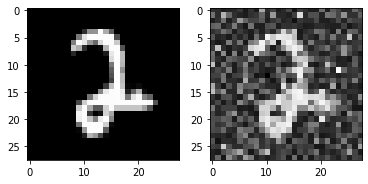

25  :  0.6947940229733794 25
50  :  0.7047423813468191 25
75  :  0.719812262562817 25
100  :  0.7219446899407209 25
125  :  0.7309895029292287 25
150  :  0.7308293211271331 25
175  :  0.7308293211271331 25
200  :  0.7308293211271331 25
225  :  0.7308293211271331 25
250  :  0.7308293211271331 25
275  :  0.7334906473574829 25
300  :  0.7334906473574829 25
325  :  0.7364268763237632 25
350  :  0.737326473705752 25
375  :  0.7381146029221518 25
400  :  0.7381146029221518 25
425  :  0.7404017157240614 25
450  :  0.7410019720382164 25
475  :  0.7416665278699571 25
500  :  0.7423319008153444 25
525  :  0.7424279585028462 25
550  :  0.7437394003051242 25
575  :  0.7437394003051242 25
600  :  0.7451561210111951 25
625  :  0.7466363950965258 25
650  :  0.7466363950965258 25
675  :  0.7500073104747604 25
700  :  0.7530962475633927 25
725  :  0.7567709015929271 25
750  :  0.7567709015929271 25
775  :  0.7570894905424401 25
800  :  0.7570889649848044 25
825  :  0.7570889649848044 25
850  :  0.75838

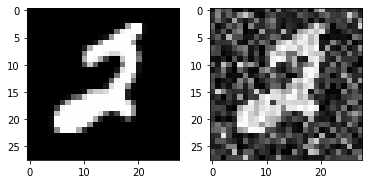

25  :  0.5984427032193839 25
50  :  0.6782301259809957 25
75  :  0.673708094020497 25
100  :  0.6867132844535135 25
125  :  0.7045124323738405 25
150  :  0.7079675584370834 25
175  :  0.7121522656120259 25
200  :  0.7121522656120259 25
225  :  0.7121522656120259 25
250  :  0.7121522656120259 25
275  :  0.7151611457278082 25
300  :  0.7151611457278082 25
325  :  0.7151611457278082 25
350  :  0.7151611457278082 25
375  :  0.7151611457278082 25
400  :  0.7203987540088915 25
425  :  0.7206361245213349 25
450  :  0.7261019584431198 25
475  :  0.7256820240641849 25
500  :  0.7256820240641849 25
525  :  0.7281797750313874 25
550  :  0.7281797750313874 25
575  :  0.7298583136657143 25
600  :  0.7314833446177131 25
625  :  0.7316569457480673 25
650  :  0.7329506540149832 25
675  :  0.7329378567527829 25
700  :  0.7337227060040399 25
725  :  0.7338490191328289 25
750  :  0.7351198651498637 25
775  :  0.7352426855533544 25
800  :  0.7353141171934322 25
825  :  0.7353175837621166 25
850  :  0.7354

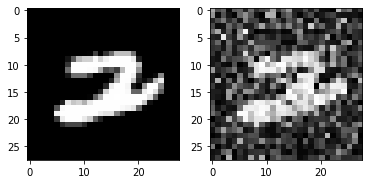

25  :  0.7289094038999759 25
50  :  0.7296392061180885 25
75  :  0.7289936871276544 25
100  :  0.7310573259899479 25
125  :  0.7412515792036319 25
150  :  0.7406644792706115 25
175  :  0.7461351338734032 25
200  :  0.7477632786848326 25
225  :  0.7476872977548772 25
250  :  0.7476872977548772 25
275  :  0.7476872977548772 25
300  :  0.7511383007596584 25
325  :  0.7511383007596584 25
350  :  0.7529741471601178 25
375  :  0.7541579404284876 25
400  :  0.7554824773021338 25
425  :  0.7595015258252866 25
450  :  0.7595659947343736 25
475  :  0.7595659947343736 25
500  :  0.7595659947343736 25
525  :  0.7605609092390359 25
550  :  0.7604898907479289 25
575  :  0.7640369761458461 25
600  :  0.7640369761458461 25
625  :  0.7644489715193796 25
650  :  0.7644489715193796 25
675  :  0.7649676036944688 25
700  :  0.7649676036944688 25
725  :  0.7649676036944688 25
750  :  0.7649676036944688 25
775  :  0.7650889026898937 25
800  :  0.765351284937632 25
825  :  0.7658049965254975 25
850  :  0.7659

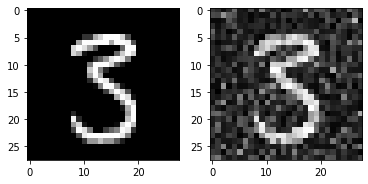

25  :  0.7505612138608095 25
50  :  0.7505612138608095 25
75  :  0.7593612827255973 25
100  :  0.759387052804839 25
125  :  0.7601212352562245 25
150  :  0.7601212352562245 25
175  :  0.7615271213799497 25
200  :  0.7614439538585455 25
225  :  0.7614439538585455 25
250  :  0.7632387347905778 25
275  :  0.7641104965916339 25
300  :  0.7641104965916339 25
325  :  0.7641104965916339 25
350  :  0.7641104965916339 25
375  :  0.7646274310365035 25
400  :  0.7663477782561765 25
425  :  0.7672976380500018 25
450  :  0.7729823768184296 25
475  :  0.7729823768184296 25
500  :  0.7743838275320369 25
525  :  0.7743838275320369 25
550  :  0.7762714226969802 25
575  :  0.7782222228954607 25
600  :  0.7782222228954607 25
625  :  0.7782222228954607 25
650  :  0.7782222228954607 25
675  :  0.7797958511517677 25
700  :  0.780017087849302 25
725  :  0.7800147969438014 25
750  :  0.7807530228145516 25
775  :  0.781156781062537 25
800  :  0.781156781062537 25
Time:  45.398300886154175  seconds
Predicted cl

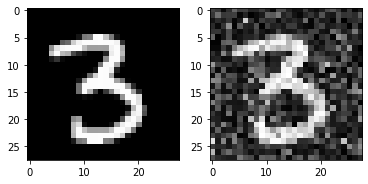

25  :  0.7719583102906881 25
50  :  0.778103083336412 25
75  :  0.7765035151259421 25
100  :  0.7862771104629457 25
125  :  0.7896325895907933 25
150  :  0.7885208627904441 25
175  :  0.789204207235684 25
200  :  0.789204207235684 25
225  :  0.7924461007407225 25
250  :  0.7922852378986517 25
275  :  0.7927593769972032 25
300  :  0.7981972633339037 25
325  :  0.7981972633339037 25
350  :  0.7984740833096573 25
375  :  0.798610846392336 25
400  :  0.8006904143091316 25
425  :  0.8006904143091316 25
450  :  0.8006904143091316 25
475  :  0.8006904143091316 25
500  :  0.8020938972828424 25
525  :  0.8051372366035554 25
550  :  0.8051372366035554 25
575  :  0.8051372366035554 25
600  :  0.8051372366035554 25
625  :  0.8051372366035554 25
650  :  0.8082614668269412 25
675  :  0.8081926151561201 25
700  :  0.8081926151561201 25
725  :  0.8081926151561201 25
750  :  0.8081926151561201 25
775  :  0.8086300887031954 25
800  :  0.809661282350755 25
Time:  44.89828324317932  seconds
Predicted clas

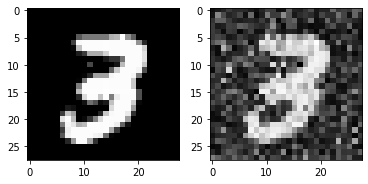

25  :  0.7628009323137044 25
50  :  0.7628009323137044 25
75  :  0.7628009323137044 25
100  :  0.7628009323137044 25
125  :  0.7628009323137044 25
150  :  0.7628009323137044 25
175  :  0.7628009323137044 25
200  :  0.7628009323137044 25
225  :  0.7628009323137044 25
250  :  0.7628009323137044 25
275  :  0.7628009323137044 25
300  :  0.7628009323137044 25
325  :  0.7628009323137044 25
350  :  0.764543014422559 25
375  :  0.7614067361263395 25
400  :  0.7614067361263395 25
425  :  0.7614067361263395 25
450  :  0.7614067361263395 25
475  :  0.7636615729505931 25
500  :  0.7636615729505931 25
525  :  0.7636615729505931 25
550  :  0.7636615729505931 25
575  :  0.7636615729505931 25
600  :  0.7636615729505931 25
625  :  0.7640400643644268 25
650  :  0.7640400643644268 25
675  :  0.7678196233414339 25
700  :  0.7674607212838953 25
725  :  0.7674607212838953 25
750  :  0.7691713746900222 25
775  :  0.7691713746900222 25
800  :  0.7695193451576778 25
Time:  44.89061117172241  seconds
Predicted 

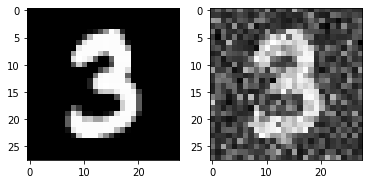

25  :  0.7519462165648313 25
50  :  0.7519462165648313 25
75  :  0.753619277749876 25
100  :  0.753619277749876 25
125  :  0.753619277749876 25
150  :  0.753619277749876 25
175  :  0.7563016857414561 25
200  :  0.7642003308757729 25
225  :  0.7642003308757729 25
250  :  0.7642003308757729 25
275  :  0.7642003308757729 25
300  :  0.7642003308757729 25
325  :  0.7722080011766871 25
350  :  0.7722043847294049 25
375  :  0.7722043847294049 25
400  :  0.7727138807291551 25
425  :  0.77279265581332 25
450  :  0.77279265581332 25
475  :  0.7738270101994598 25
500  :  0.7736058749886285 25
525  :  0.7763881010819695 25
550  :  0.7796337437701508 25
575  :  0.7788202447069051 25
600  :  0.7788202447069051 25
625  :  0.7820063275658373 25
650  :  0.7845228907103703 25
675  :  0.7845228907103703 25
700  :  0.7845228907103703 25
725  :  0.7845228907103703 25
750  :  0.7845228907103703 25
775  :  0.7845228907103703 25
800  :  0.7845228907103703 25
Time:  45.174797773361206  seconds
Predicted class:

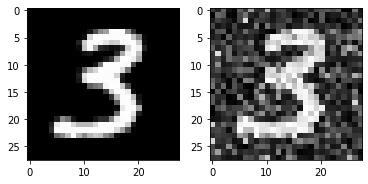

25  :  0.6575595646658219 25
50  :  0.6708025121664895 25
75  :  0.7226180284145673 25
100  :  0.7226180284145673 25
125  :  0.7226180284145673 25
150  :  0.7226180284145673 25
175  :  0.7226180284145673 25
200  :  0.7226180284145673 25
225  :  0.7246014865584001 25
250  :  0.7226180284145673 25
275  :  0.7236900750274592 25
300  :  0.7236900750274592 25
325  :  0.7276100821509627 25
350  :  0.7273947956414107 25
375  :  0.7305523659445072 25
400  :  0.730527648490189 25
425  :  0.730527648490189 25
450  :  0.7333616331623279 25
475  :  0.7333616331623279 25
500  :  0.7333616331623279 25
525  :  0.7333616331623279 25
550  :  0.7346884383272901 25
575  :  0.7346880974643483 25
600  :  0.7346880974643483 25
625  :  0.735908644764969 25
650  :  0.735908644764969 25
675  :  0.735908644764969 25
700  :  0.736320949983778 25
725  :  0.7371296446328508 25
750  :  0.7378805646513376 25
775  :  0.7384493102816669 25
800  :  0.7384493102816669 25
825  :  0.7384714431790447 25
850  :  0.739446693

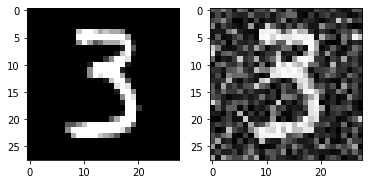

25  :  0.06120052681317917 25
50  :  0.6742027380599663 25
75  :  0.7133859864288152 25
100  :  0.7124128966797357 25
125  :  0.7185135389249787 25
150  :  0.7091138683713484 25
175  :  0.7221783023553732 25
200  :  0.7221997343883492 25
225  :  0.7253792418702898 25
250  :  0.7251090623054137 25
275  :  0.729694305997917 25
300  :  0.729694305997917 25
325  :  0.729694305997917 25
350  :  0.729694305997917 25
375  :  0.729694305997917 25
400  :  0.7362657068609895 25
425  :  0.7362657068609895 25
450  :  0.7362657068609895 25
475  :  0.7366572680728962 25
500  :  0.736795957348233 25
525  :  0.737275767610912 25
550  :  0.7376493379201281 25
575  :  0.7397425239320369 25
600  :  0.7411939444624447 25
625  :  0.7419198506824811 25
650  :  0.7425578986730761 25
675  :  0.7425128311637664 25
700  :  0.7425128311637664 25
725  :  0.744455039245275 25
750  :  0.7451488252981591 25
775  :  0.7460785567412962 25
800  :  0.7465073175170098 25
825  :  0.7463803809610787 25
850  :  0.7463803809

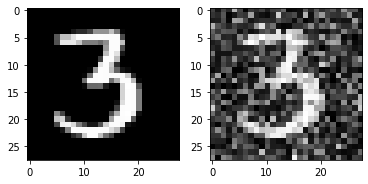

25  :  -0.012615275838121998 25
50  :  0.6498164218281887 25
75  :  0.6963842165147875 25
100  :  0.7092866143151615 25
125  :  0.7001653724589593 25
150  :  0.7001653724589593 25
175  :  0.7001653724589593 25
200  :  0.7001653724589593 25
225  :  0.7001653724589593 25
250  :  0.7001653724589593 25
275  :  0.7027196544654158 25
300  :  0.7027196544654158 25
325  :  0.7027196544654158 25
350  :  0.704710102198092 25
375  :  0.7046356134898073 25
400  :  0.7085258954278568 25
425  :  0.7085258954278568 25
450  :  0.7085258954278568 25
475  :  0.7169994692196094 25
500  :  0.7168748802685512 25
525  :  0.7168748802685512 25
550  :  0.7217935675267639 25
575  :  0.7241183189558991 25
600  :  0.7241183189558991 25
625  :  0.7241183189558991 25
650  :  0.7241183189558991 25
675  :  0.7241183189558991 25
700  :  0.7241183189558991 25
725  :  0.7241757673831879 25
750  :  0.726120093605494 25
775  :  0.7268111032285031 25
800  :  0.7274624724708658 25
825  :  0.7276067807621017 25
850  :  0.72

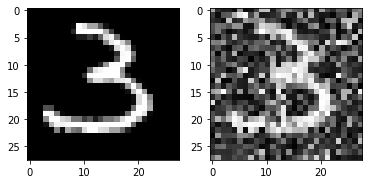

25  :  0.48584917367534425 25
50  :  0.7187007953778126 25
75  :  0.755707923207847 25
100  :  0.7740484751071055 25
125  :  0.7770710561862466 25
150  :  0.7770710561862466 25
175  :  0.7779691789868461 25
200  :  0.7779691789868461 25
225  :  0.7779691789868461 25
250  :  0.7833976113865484 25
275  :  0.7872245962447602 25
300  :  0.7872245962447602 25
325  :  0.7872245962447602 25
350  :  0.7872245962447602 25
375  :  0.7872245962447602 25
400  :  0.7872245962447602 25
425  :  0.7888574311793279 25
450  :  0.7931324747346253 25
475  :  0.795048543794745 25
500  :  0.7970941139874279 25
525  :  0.7970941139874279 25
550  :  0.7983599549489362 25
575  :  0.8005537352292711 25
600  :  0.8013270367903625 25
625  :  0.8027518704552943 25
650  :  0.802767570860877 25
675  :  0.8040365200274544 25
700  :  0.804682574488226 25
725  :  0.8054116904783097 25
750  :  0.8054290470053903 25
775  :  0.80549293966716 25
800  :  0.8065168396275568 25
825  :  0.8065168396275568 25
850  :  0.80835036

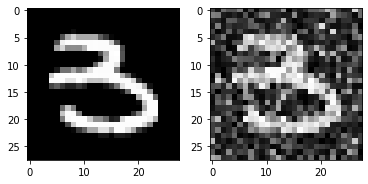

25  :  0.6864268638506812 25
50  :  0.6866615875131675 25
75  :  0.693970330682174 25
100  :  0.6982308316188641 25
125  :  0.6982308316188641 25
150  :  0.6982308316188641 25
175  :  0.6982308316188641 25
200  :  0.6982308316188641 25
225  :  0.6982308316188641 25
250  :  0.6982308316188641 25
275  :  0.6994053288388201 25
300  :  0.7014636084912012 25
325  :  0.7035322540580982 25
350  :  0.7032017145305698 25
375  :  0.7035858644618865 25
400  :  0.7069873009250215 25
425  :  0.7073551855967513 25
450  :  0.7076027317505847 25
475  :  0.7076027317505847 25
500  :  0.7076027317505847 25
525  :  0.7096373099728709 25
550  :  0.7105055766212184 25
575  :  0.7119358274335303 25
600  :  0.7133990864941012 25
625  :  0.7134894457577522 25
650  :  0.7136762106466905 25
675  :  0.7143462069320101 25
700  :  0.7148370341634109 25
725  :  0.714837717315542 25
750  :  0.7161202638162507 25
775  :  0.7163472658194527 25
800  :  0.7189027213100069 25
Time:  45.04679870605469  seconds
Predicted c

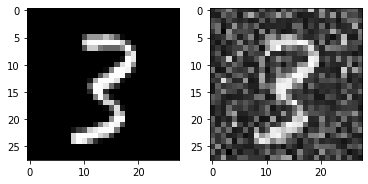

25  :  0.68869930862033 25
50  :  0.7124612541435155 25
75  :  0.715319780692435 25
100  :  0.715319780692435 25
125  :  0.715319780692435 25
150  :  0.715319780692435 25
175  :  0.7214039237903331 25
200  :  0.7214039237903331 25
225  :  0.7240507510721166 25
250  :  0.7302573596316293 25
275  :  0.7302573596316293 25
300  :  0.7302573596316293 25
325  :  0.7329878058634349 25
350  :  0.7377549643800887 25
375  :  0.7377549643800887 25
400  :  0.7398008045596159 25
425  :  0.7399421212307062 25
450  :  0.7409718243938673 25
475  :  0.7409344242731404 25
500  :  0.7417025856132409 25
525  :  0.742548868267987 25
550  :  0.7435712759495274 25
575  :  0.7444919573272297 25
600  :  0.7450866365370703 25
625  :  0.7450866365370703 25
650  :  0.7452222429399298 25
675  :  0.7460202553638537 25
700  :  0.746857033322145 25
725  :  0.748145547880418 25
750  :  0.748145547880418 25
775  :  0.7484363797225378 25
800  :  0.7488832147741391 25
825  :  0.7497844458644315 25
Time:  46.3358395099639

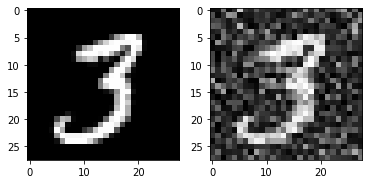

25  :  0.3580690731154735 25
50  :  0.7080512210172633 25
75  :  0.6888323666565292 25
100  :  0.7108287449973762 25
125  :  0.7119957691737059 25
150  :  0.7318957174712124 25
175  :  0.722264502719186 25
200  :  0.7265879725633997 25
225  :  0.7254566414223499 25
250  :  0.7289091794531117 25
275  :  0.7299121068260128 25
300  :  0.736179593772806 25
325  :  0.7362226213545934 25
350  :  0.7362226213545934 25
375  :  0.7362226213545934 25
400  :  0.7362226213545934 25
425  :  0.7375464945378987 25
450  :  0.7377532564664262 25
475  :  0.7443339966556181 25
500  :  0.7443681266844508 25
525  :  0.7443681266844508 25
550  :  0.7465024638352192 25
575  :  0.746473773704538 25
600  :  0.747627766256266 25
625  :  0.747627766256266 25
650  :  0.7483436395147661 25
675  :  0.7493568237140513 25
700  :  0.7505012300020322 25
725  :  0.7505924928771615 25
750  :  0.7505924928771615 25
775  :  0.7505924928771615 25
800  :  0.7522319656792356 25
825  :  0.7528612440643738 25
850  :  0.75286124

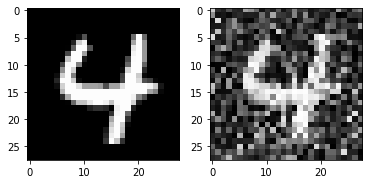

25  :  0.6587869961994193 25
50  :  0.762415518620686 25
75  :  0.7700508747694225 25
100  :  0.7700508747694225 25
125  :  0.7700508747694225 25
150  :  0.7700508747694225 25
175  :  0.7732065121572413 25
200  :  0.775377134246152 25
225  :  0.7771315711849334 25
250  :  0.775377134246152 25
275  :  0.7777008322262484 25
300  :  0.7777008322262484 25
325  :  0.7777008322262484 25
350  :  0.7777008322262484 25
375  :  0.779617792574753 25
400  :  0.7844391096893714 25
425  :  0.7847247328438121 25
450  :  0.7853569769497672 25
475  :  0.7856156670835333 25
500  :  0.7876393794845729 25
525  :  0.7876862640065995 25
550  :  0.7882076819140555 25
575  :  0.7882076819140555 25
600  :  0.7882076819140555 25
625  :  0.7889397445510326 25
650  :  0.7913494534207142 25
675  :  0.7913494534207142 25
700  :  0.7913494534207142 25
725  :  0.7935103156512667 25
750  :  0.7992207454616147 25
775  :  0.7995546387574859 25
800  :  0.7995546387574859 25
825  :  0.7995546387574859 25
Time:  46.5314495

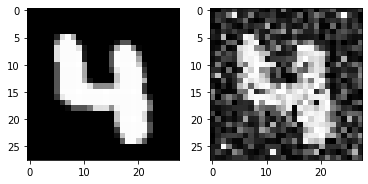

25  :  0.07243077158942904 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


50  :  0.5754089352823477 25
75  :  0.7051612294637668 25
100  :  0.7088872118767434 25
125  :  0.7089183192945423 25
150  :  0.7089183192945423 25
175  :  0.7089183192945423 25
200  :  0.7089183192945423 25
225  :  0.7089183192945423 25
250  :  0.7089183192945423 25
275  :  0.7089183192945423 25
300  :  0.7089183192945423 25
325  :  0.7089183192945423 25
350  :  0.7089183192945423 25
375  :  0.7132229754599377 25
400  :  0.7132229754599377 25
425  :  0.7163456954523244 25
450  :  0.7212964273203906 25
475  :  0.7212471023360681 25
500  :  0.7250106073230889 25
525  :  0.7272108601658185 25
550  :  0.7272108601658185 25
575  :  0.7272108601658185 25
600  :  0.7272108601658185 25
625  :  0.7272108601658185 25
650  :  0.7272108601658185 25
675  :  0.7272108601658185 25
700  :  0.7297131851276422 25
725  :  0.7292971060918841 25
750  :  0.7292971060918841 25
775  :  0.7292971060918841 25
800  :  0.7292971060918841 25
825  :  0.7292971060918841 25
850  :  0.7310063176255402 25
Time:  47.45

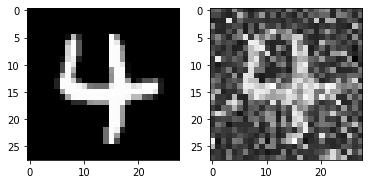

25  :  0.632799542962859 25
50  :  0.6735561923457442 25
75  :  0.6754865071077107 25
100  :  0.6754865071077107 25
125  :  0.6754865071077107 25
150  :  0.6754865071077107 25
175  :  0.6805876513018315 25
200  :  0.6798923274407125 25
225  :  0.6798923274407125 25
250  :  0.6798923274407125 25
275  :  0.6840921375665634 25
300  :  0.6780882315256747 25
325  :  0.678810811410978 25
350  :  0.6813468536814101 25
375  :  0.6813468536814101 25
400  :  0.691398465290644 25
425  :  0.691398465290644 25
450  :  0.6934802466006519 25
475  :  0.6941171838446425 25
500  :  0.6941171838446425 25
525  :  0.6941171838446425 25
550  :  0.6941171838446425 25
575  :  0.7007078139747644 25
600  :  0.7007078139747644 25
625  :  0.7007078139747644 25
650  :  0.7007078139747644 25
675  :  0.7027814656879978 25
700  :  0.7028140237296052 25
725  :  0.7038283761901301 25
750  :  0.7040174154445318 25
775  :  0.7060010495955124 25
800  :  0.7066255220220882 25
825  :  0.7072645191916034 25
850  :  0.7072636

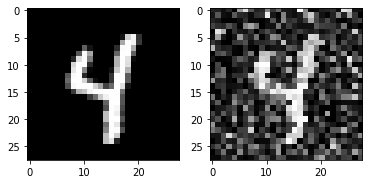

25  :  0.5678128517708954 25
50  :  0.6495213330015726 25
75  :  0.6686571974973375 25
100  :  0.6686571974973375 25
125  :  0.6712374979398377 25
150  :  0.673942045946127 25
175  :  0.6723221574542317 25
200  :  0.6723221574542317 25
225  :  0.6723221574542317 25
250  :  0.6723221574542317 25
275  :  0.6723221574542317 25
300  :  0.6723221574542317 25
325  :  0.6723221574542317 25
350  :  0.6791947433855647 25
375  :  0.6806072701924206 25
400  :  0.6806072701924206 25
425  :  0.6806072701924206 25
450  :  0.681047704839439 25
475  :  0.6824293350304679 25
500  :  0.6828778397243578 25
525  :  0.6828778397243578 25
550  :  0.6856376605736523 25
575  :  0.6874956316804054 25
600  :  0.6875520852923418 25
625  :  0.6916629402861735 25
650  :  0.691641727413794 25
675  :  0.691641727413794 25
700  :  0.6922759598088378 25
725  :  0.6928763923707759 25
750  :  0.6951268332112843 25
775  :  0.6951268332112843 25
800  :  0.696019719346004 25
825  :  0.6960100594876938 25
850  :  0.69636888

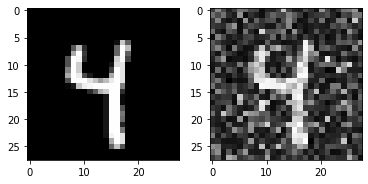

25  :  0.6848287324940618 25
50  :  0.6946005352643866 25
75  :  0.6946507816678111 25
100  :  0.6946507816678111 25
125  :  0.6946507816678111 25
150  :  0.6946507816678111 25
175  :  0.6946507816678111 25
200  :  0.6958655878191773 25
225  :  0.6958655878191773 25
250  :  0.6958655878191773 25
275  :  0.6980936213913261 25
300  :  0.7002405515813239 25
325  :  0.7001936331411712 25
350  :  0.7001936331411712 25
375  :  0.7001936331411712 25
400  :  0.7006797307106108 25
425  :  0.7020170507595646 25
450  :  0.7034631458344236 25
475  :  0.7032043198320788 25
500  :  0.7038444986146801 25
525  :  0.7075216409045015 25
550  :  0.7074804202436322 25
575  :  0.7074804202436322 25
600  :  0.7090937757724188 25
625  :  0.7095201052277679 25
650  :  0.709963831864731 25
675  :  0.7111394252977763 25
700  :  0.7111394252977763 25
725  :  0.7138127533803716 25
750  :  0.7145886345167618 25
775  :  0.7158936273283129 25
800  :  0.7158624386040437 25
Time:  44.699910402297974  seconds
Predicted

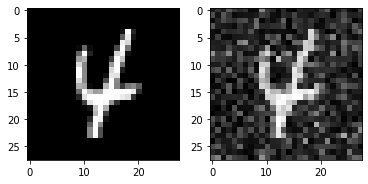

25  :  0.7005460309683424 25
50  :  0.7025875553200065 25
75  :  0.7055828278404769 25
100  :  0.7055828278404769 25
125  :  0.7081132185920743 25
150  :  0.7081132185920743 25
175  :  0.7081132185920743 25
200  :  0.7110475212805791 25
225  :  0.7103756068784456 25
250  :  0.7103756068784456 25
275  :  0.7211731995810396 25
300  :  0.7216580002601829 25
325  :  0.7296147991402856 25
350  :  0.7296147991402856 25
375  :  0.7296147991402856 25
400  :  0.7296147991402856 25
425  :  0.7296147991402856 25
450  :  0.7296147991402856 25
475  :  0.7296147991402856 25
500  :  0.7345752982458558 25
525  :  0.7347772408334617 25
550  :  0.734744073129963 25
575  :  0.7366261692130829 25
600  :  0.7368531469976081 25
625  :  0.7388560558231705 25
650  :  0.7392175725828791 25
675  :  0.7397832171483796 25
700  :  0.7416281740890374 25
725  :  0.7424909950536398 25
750  :  0.7425905394591219 25
775  :  0.7455160277133195 25
800  :  0.7465147505933534 25
825  :  0.7471955297667876 25
850  :  0.7471

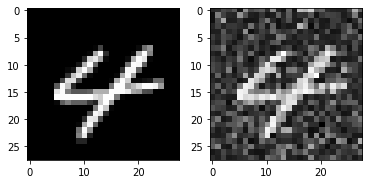

25  :  0.694531567505577 25
50  :  0.694531567505577 25
75  :  0.6998497710929389 25
100  :  0.6998497710929389 25
125  :  0.7009964302127633 25
150  :  0.7009964302127633 25
175  :  0.7009964302127633 25
200  :  0.7015672652450576 25
225  :  0.7058329632711721 25
250  :  0.7068693731655804 25
275  :  0.7126504117078261 25
300  :  0.7166560115665663 25
325  :  0.7175400422737046 25
350  :  0.7175400422737046 25
375  :  0.7175400422737046 25
400  :  0.7175400422737046 25
425  :  0.7206709407618079 25
450  :  0.7250634521791818 25
475  :  0.7265302792165429 25
500  :  0.7265302792165429 25
525  :  0.7282972765531681 25
550  :  0.7286248799421449 25
575  :  0.7286248799421449 25
600  :  0.7299956446619202 25
625  :  0.731013946733201 25
650  :  0.7313292383396189 25
675  :  0.7345047336636676 25
700  :  0.7351569742434834 25
725  :  0.735889721775074 25
750  :  0.7359884470044908 25
775  :  0.7367514517542205 25
800  :  0.7368715936552969 25
Time:  45.026734352111816  seconds
Predicted cl

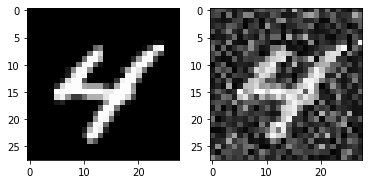

25  :  0.6697432388633411 25
50  :  0.6697432388633411 25
75  :  0.6697432388633411 25
100  :  0.6697432388633411 25
125  :  0.6697432388633411 25
150  :  0.6697432388633411 25
175  :  0.6756686336720125 25
200  :  0.6756686336720125 25
225  :  0.6781802886395527 25
250  :  0.6818880163338141 25
275  :  0.6818880163338141 25
300  :  0.6818880163338141 25
325  :  0.6851737686385527 25
350  :  0.6851133430248455 25
375  :  0.6904680701837616 25
400  :  0.6904680701837616 25
425  :  0.6904680701837616 25
450  :  0.6904680701837616 25
475  :  0.6913177962465705 25
500  :  0.6912934501687503 25
525  :  0.6912934501687503 25
550  :  0.6927481866980423 25
575  :  0.6927481866980423 25
600  :  0.6927481866980423 25
625  :  0.6933183971580659 25
650  :  0.6941005821148883 25
675  :  0.6939387916264294 25
700  :  0.6957919732709444 25
725  :  0.6959298132680216 25
750  :  0.6972243747934662 25
775  :  0.6972243747934662 25
800  :  0.7008276245054561 25
Time:  44.56861209869385  seconds
Predicted

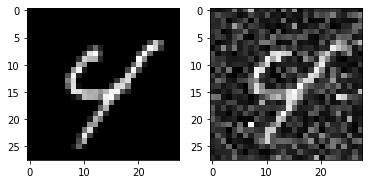

25  :  0.6824642200972015 25
50  :  0.6824642200972015 25
75  :  0.6811562081738822 25
100  :  0.6811562081738822 25
125  :  0.682009055719808 25
150  :  0.6797901040029037 25
175  :  0.6800190692987002 25
200  :  0.6866931719091897 25
225  :  0.6840131001698136 25
250  :  0.6865002494706206 25
275  :  0.6864807729459624 25
300  :  0.6864807729459624 25
325  :  0.6864807729459624 25
350  :  0.6895479000658128 25
375  :  0.6898965796067932 25
400  :  0.6929174094905056 25
425  :  0.693037145421321 25
450  :  0.6935649279239016 25
475  :  0.6953140833999499 25
500  :  0.6953459888417991 25
525  :  0.695855474058336 25
550  :  0.7008462937240628 25
575  :  0.7022415304824238 25
600  :  0.7019827953683929 25
625  :  0.7019827953683929 25
650  :  0.7028112021828741 25
675  :  0.7035603608754992 25
700  :  0.7060321601530803 25
725  :  0.7060321601530803 25
750  :  0.7060321601530803 25
775  :  0.7065634278804349 25
800  :  0.7064164399508358 25
Time:  44.98499584197998  seconds
Predicted cl

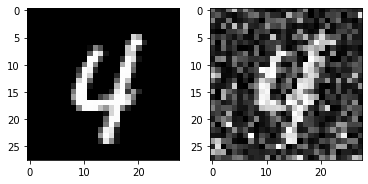

25  :  0.6714094816400424 25
50  :  0.6714094816400424 25
75  :  0.6777209815631628 25
100  :  0.6661808389315332 25
125  :  0.6784233492218729 25
150  :  0.6743582079550581 25
175  :  0.6832661251335345 25
200  :  0.6796391872493189 25
225  :  0.6890233928610173 25
250  :  0.6890233928610173 25
275  :  0.6890233928610173 25
300  :  0.6890233928610173 25
325  :  0.6890233928610173 25
350  :  0.6890233928610173 25
375  :  0.6924289368836217 25
400  :  0.6940916339205593 25
425  :  0.7028067635557886 25
450  :  0.7027377000960577 25
475  :  0.7027377000960577 25
500  :  0.7027377000960577 25
525  :  0.7027377000960577 25
550  :  0.7027377000960577 25
575  :  0.7027377000960577 25
600  :  0.7030935443740696 25
625  :  0.7030935443740696 25
650  :  0.7030935443740696 25
675  :  0.7036996920109541 25
700  :  0.7036996920109541 25
725  :  0.7050083171719924 25
750  :  0.7058488444073052 25
775  :  0.7058488444073052 25
800  :  0.7061626192625954 25
825  :  0.7071988171919248 25
850  :  0.707

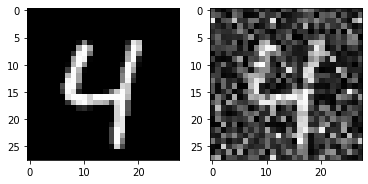

25  :  0.6775399126659972 25
50  :  0.6775399126659972 25
75  :  0.6775399126659972 25
100  :  0.6775399126659972 25
125  :  0.6775399126659972 25
150  :  0.6775399126659972 25
175  :  0.6775399126659972 25
200  :  0.6775399126659972 25
225  :  0.6775399126659972 25
250  :  0.6775399126659972 25
275  :  0.6801896361922892 25
300  :  0.6797142447858242 25
325  :  0.6799033433207782 25
350  :  0.680060002640462 25
375  :  0.680060002640462 25
400  :  0.680060002640462 25
425  :  0.680060002640462 25
450  :  0.680060002640462 25
475  :  0.680060002640462 25
500  :  0.680060002640462 25
525  :  0.6816693926523115 25
550  :  0.6816693926523115 25
575  :  0.6825320248325439 25
600  :  0.6816693926523115 25
625  :  0.6872622988159618 25
650  :  0.6852382093876075 25
675  :  0.6878980340313324 25
700  :  0.6882080190239441 25
725  :  0.6882080190239441 25
750  :  0.6882080190239441 25
775  :  0.6882080190239441 25
800  :  0.6882080190239441 25
Time:  44.36344623565674  seconds
Predicted class:

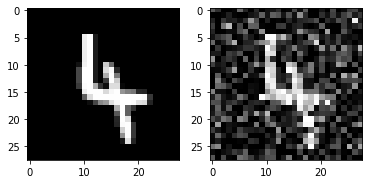

25  :  0.6308731779848898 25
50  :  0.6308731779848898 25
75  :  0.6423875381801594 25
100  :  0.6420522110252854 25
125  :  0.6420522110252854 25
150  :  0.6420522110252854 25
175  :  0.6420522110252854 25
200  :  0.6420522110252854 25
225  :  0.6420522110252854 25
250  :  0.6420522110252854 25
275  :  0.6420522110252854 25
300  :  0.643509228774529 25
325  :  0.643509228774529 25
350  :  0.6482619008123304 25
375  :  0.6473492049929556 25
400  :  0.6473492049929556 25
425  :  0.654187379111605 25
450  :  0.6562668482550679 25
475  :  0.6562668482550679 25
500  :  0.6562668482550679 25
525  :  0.6562668482550679 25
550  :  0.6562668482550679 25
575  :  0.6562668482550679 25
600  :  0.6562668482550679 25
625  :  0.6563539863143661 25
650  :  0.6575414754012697 25
675  :  0.6588923852936932 25
700  :  0.6583696790149547 25
725  :  0.6603393205296834 25
750  :  0.6639474661976884 25
775  :  0.6654603429876365 25
800  :  0.6654603429876365 25
825  :  0.6654714393550085 25
850  :  0.665471

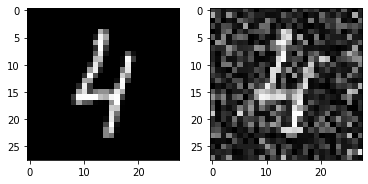

25  :  0.6569379656724668 25
50  :  0.6569379656724668 25
75  :  0.6593812465658232 25
100  :  0.6593812465658232 25
125  :  0.6593812465658232 25
150  :  0.6593812465658232 25
175  :  0.6593812465658232 25
200  :  0.6641514313850341 25
225  :  0.6645077870506618 25
250  :  0.6665679722602794 25
275  :  0.6721524711286159 25
300  :  0.6721524711286159 25
325  :  0.6721524711286159 25
350  :  0.6721524711286159 25
375  :  0.6728226396033086 25
400  :  0.6737399823037569 25
425  :  0.6737892768716187 25
450  :  0.6737834097527257 25
475  :  0.6737834097527257 25
500  :  0.6739638473316266 25
525  :  0.6742761197633226 25
550  :  0.6752158050198703 25
575  :  0.6767755041627397 25
600  :  0.6778909479651016 25
625  :  0.6778424726612511 25
650  :  0.6778424726612511 25
675  :  0.6778424726612511 25
700  :  0.6790392138683736 25
725  :  0.6800345214676937 25
750  :  0.6806904736723902 25
775  :  0.6817806598300671 25
800  :  0.6817641186935037 25
Time:  44.76234292984009  seconds
Predicted

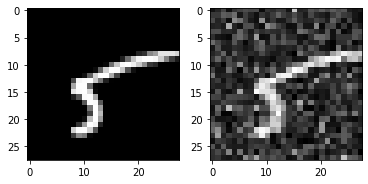

25  :  0.6461569888065155 25
50  :  0.6465875013927418 25
75  :  0.6497655764884621 25
100  :  0.6566036617012003 25
125  :  0.6612504870386811 25
150  :  0.6581901940628714 25
175  :  0.6581901940628714 25
200  :  0.6584610822106043 25
225  :  0.6593309812435382 25
250  :  0.6593309812435382 25
275  :  0.6593309812435382 25
300  :  0.6593309812435382 25
325  :  0.6593309812435382 25
350  :  0.6688001362783382 25
375  :  0.6693129334341781 25
400  :  0.6695824736339014 25
425  :  0.6698791457530644 25
450  :  0.670488148423838 25
475  :  0.6747633922628329 25
500  :  0.6744617607262398 25
525  :  0.6744617607262398 25
550  :  0.6744617607262398 25
575  :  0.6744617607262398 25
600  :  0.6799493911179039 25
625  :  0.6797957456547488 25
650  :  0.6819352119997207 25
675  :  0.6822911302828261 25
700  :  0.6820766260702493 25
725  :  0.6824346072117813 25
750  :  0.6829316483754565 25
775  :  0.6840854720617561 25
800  :  0.6844341082008828 25
Time:  45.02772784233093  seconds
Predicted 

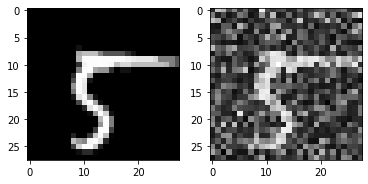

25  :  0.785988235810599 25
50  :  0.785988235810599 25
75  :  0.7941943677068719 25
100  :  0.7941943677068719 25
125  :  0.7941943677068719 25
150  :  0.7941943677068719 25
175  :  0.7941943677068719 25
200  :  0.8013485607285518 25
225  :  0.8004177963681671 25
250  :  0.8004177963681671 25
275  :  0.8004177963681671 25
300  :  0.8057384505431459 25
325  :  0.8057384505431459 25
350  :  0.8057384505431459 25
375  :  0.8057384505431459 25
400  :  0.8057384505431459 25
425  :  0.8057384505431459 25
450  :  0.8068227697897479 25
475  :  0.8095481657865771 25
500  :  0.8095471646976009 25
525  :  0.809604554790891 25
550  :  0.8095590600878558 25
575  :  0.8099313319939607 25
600  :  0.8120141975271833 25
625  :  0.8120360649813816 25
650  :  0.8130105546779953 25
675  :  0.8134664960519052 25
700  :  0.8134664960519052 25
725  :  0.8134664960519052 25
750  :  0.8140578216567038 25
775  :  0.8155919031781804 25
800  :  0.8155969487994337 25
Time:  44.443150758743286  seconds
Predicted c

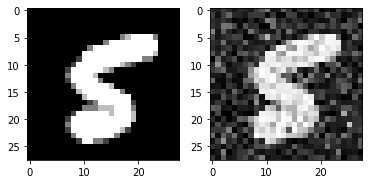

25  :  0.45138444978442094 25
50  :  0.7420642319010353 25
75  :  0.7498837195356486 25
100  :  0.7564341306091715 25
125  :  0.7570658304814504 25
150  :  0.7613742972375396 25
175  :  0.7652128593511929 25
200  :  0.7661653549220027 25
225  :  0.7658621273808133 25
250  :  0.769651903553586 25
275  :  0.7705856241492647 25
300  :  0.7756455995822358 25
325  :  0.776010338890462 25
350  :  0.7806220590226214 25
375  :  0.7805549219892068 25
400  :  0.7814607965472558 25
425  :  0.7847077564456284 25
450  :  0.7844413631659608 25
475  :  0.7848332815098746 25
500  :  0.7903972167492525 25
525  :  0.7903972167492525 25
550  :  0.7903972167492525 25
575  :  0.790647568893736 25
600  :  0.7913354547084168 25
625  :  0.7921882872579256 25
650  :  0.7942301586255804 25
675  :  0.7941637314139105 25
700  :  0.794355559726051 25
725  :  0.7950494959318084 25
750  :  0.796586605383907 25
775  :  0.797002360291003 25
800  :  0.7983422046383326 25
825  :  0.7983416029572716 25
Time:  47.25270605

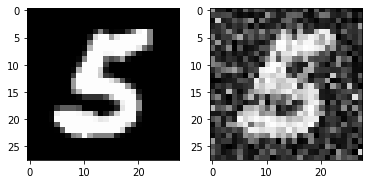

25  :  0.7553283968361901 25
50  :  0.7553283968361901 25
75  :  0.7614882858353899 25
100  :  0.7626270922724828 25
125  :  0.7635934180956037 25
150  :  0.7636288744869091 25
175  :  0.7634938580618824 25
200  :  0.7668506366478614 25
225  :  0.7680857974162474 25
250  :  0.7680857974162474 25
275  :  0.7680857974162474 25
300  :  0.7728366786675991 25
325  :  0.7740938295869134 25
350  :  0.7784384995320744 25
375  :  0.7784591597480295 25
400  :  0.7784591597480295 25
425  :  0.7784591597480295 25
450  :  0.7784591597480295 25
475  :  0.7784591597480295 25
500  :  0.7784591597480295 25
525  :  0.7804674296166265 25
550  :  0.7817588192656277 25
575  :  0.7822572658618614 25
600  :  0.7825103155684492 25
625  :  0.7857174048117574 25
650  :  0.7866880743048958 25
675  :  0.7868265577303543 25
700  :  0.7867824190989352 25
725  :  0.7877000877375341 25
750  :  0.7885221459766145 25
775  :  0.7891448552426281 25
800  :  0.7900546571452598 25
Time:  46.90542149543762  seconds
Predicted

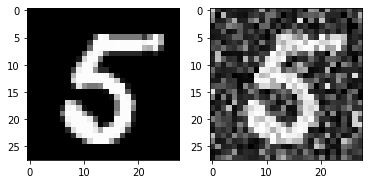

25  :  0.7380360941875054 25
50  :  0.7380360941875054 25
75  :  0.7411769600496759 25
100  :  0.7411769600496759 25
125  :  0.7411769600496759 25
150  :  0.7411769600496759 25
175  :  0.7411769600496759 25
200  :  0.7411769600496759 25
225  :  0.7411769600496759 25
250  :  0.7411769600496759 25
275  :  0.7411769600496759 25
300  :  0.7411769600496759 25
325  :  0.7423728909935146 25
350  :  0.7414722105307983 25
375  :  0.7414722105307983 25
400  :  0.7426519610052319 25
425  :  0.7414722105307983 25
450  :  0.7414722105307983 25
475  :  0.7414722105307983 25
500  :  0.7414722105307983 25
525  :  0.7414722105307983 25
550  :  0.7421279957304165 25
575  :  0.7427028119725361 25
600  :  0.7427028119725361 25
625  :  0.7427028119725361 25
650  :  0.7463905181640531 25
675  :  0.7472144213151943 25
700  :  0.7472144213151943 25
725  :  0.7472144213151943 25
750  :  0.7472144213151943 25
775  :  0.7472144213151943 25
800  :  0.7472144213151943 25
Time:  44.85079836845398  seconds
Predicted

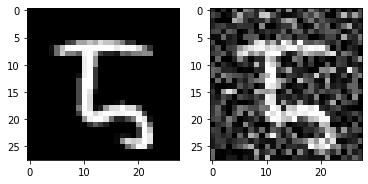

25  :  0.7189244357430553 25
50  :  0.7189244357430553 25
75  :  0.7219846575156259 25
100  :  0.7331843769777217 25
125  :  0.7331843769777217 25
150  :  0.7331843769777217 25
175  :  0.7331843769777217 25
200  :  0.7331843769777217 25
225  :  0.7360415926468142 25
250  :  0.7360415926468142 25
275  :  0.7360415926468142 25
300  :  0.7396618329391262 25
325  :  0.7390036247976363 25
350  :  0.7390036247976363 25
375  :  0.740530374730019 25
400  :  0.743285612162105 25
425  :  0.743285612162105 25
450  :  0.743285612162105 25
475  :  0.743285612162105 25
500  :  0.743285612162105 25
525  :  0.7458386458750192 25
550  :  0.7458386458750192 25
575  :  0.7481901974729545 25
600  :  0.7481292259757364 25
625  :  0.7481292259757364 25
650  :  0.7489992779146026 25
675  :  0.7505008890338213 25
700  :  0.7505008890338213 25
725  :  0.7505008890338213 25
750  :  0.7514559298926764 25
775  :  0.7518089618403728 25
800  :  0.7518089618403728 25
825  :  0.7518089618403728 25
850  :  0.751808961

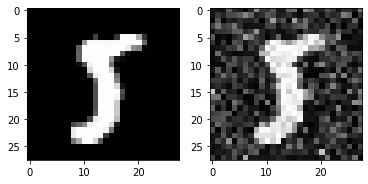

25  :  0.6675045165538307 25
50  :  0.6675045165538307 25
75  :  0.6663945739161897 25
100  :  0.6722280374961019 25
125  :  0.6776986747580132 25
150  :  0.6757812095679918 25
175  :  0.6755422190443454 25
200  :  0.6900411647032169 25
225  :  0.6882291147495941 25
250  :  0.6882291147495941 25
275  :  0.6882291147495941 25
300  :  0.6882291147495941 25
325  :  0.6882291147495941 25
350  :  0.6900346697488833 25
375  :  0.6896059772631824 25
400  :  0.6916755674723738 25
425  :  0.6915571056857832 25
450  :  0.6928669564818719 25
475  :  0.6955724830772234 25
500  :  0.6955724830772234 25
525  :  0.6956584570838389 25
550  :  0.6956584570838389 25
575  :  0.6960053024686947 25
600  :  0.6960419882939008 25
625  :  0.6980907948246582 25
650  :  0.6977017812344674 25
675  :  0.6982932584260618 25
700  :  0.6985105067727346 25
725  :  0.6999950405942472 25
750  :  0.7002306044091057 25
775  :  0.7003629152286402 25
800  :  0.7003342975389918 25
825  :  0.7005346479759992 25
850  :  0.700

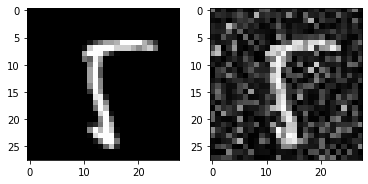

25  :  0.672466274448571 25
50  :  0.697294846262567 25
75  :  0.6931413766852321 25
100  :  0.6931413766852321 25
125  :  0.6969568114981817 25
150  :  0.6969568114981817 25
175  :  0.7036972741150351 25
200  :  0.6969568114981817 25
225  :  0.6969568114981817 25
250  :  0.6969568114981817 25
275  :  0.6969568114981817 25
300  :  0.6969568114981817 25
325  :  0.7043406573137583 25
350  :  0.705100017486753 25
375  :  0.705100017486753 25
400  :  0.705100017486753 25
425  :  0.7092897662430818 25
450  :  0.709191965149356 25
475  :  0.7175959679022428 25
500  :  0.7175959679022428 25
525  :  0.7192765013718118 25
550  :  0.7209674151038417 25
575  :  0.7209674151038417 25
600  :  0.7230843989216423 25
625  :  0.7230843989216423 25
650  :  0.7237229084829571 25
675  :  0.7251753130332718 25
700  :  0.7266835537396588 25
725  :  0.7269016239850119 25
750  :  0.7273577897698398 25
775  :  0.731368437303231 25
800  :  0.7313632539984782 25
825  :  0.7313632539984782 25
Time:  46.5614733695

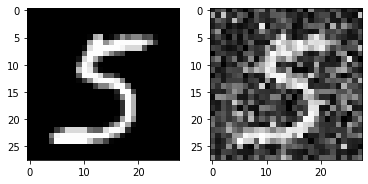

25  :  0.7488626705643358 25
50  :  0.7579618875095819 25
75  :  0.7639482102396356 25
100  :  0.7685498781579141 25
125  :  0.7685498781579141 25
150  :  0.7685498781579141 25
175  :  0.7685498781579141 25
200  :  0.769053429792309 25
225  :  0.7704483280438015 25
250  :  0.775944593748943 25
275  :  0.7761899474353662 25
300  :  0.7768962728053155 25
325  :  0.7768207419786352 25
350  :  0.7794338458492731 25
375  :  0.779418717444486 25
400  :  0.7822864493044014 25
425  :  0.7857669445219677 25
450  :  0.7854060348388912 25
475  :  0.7854060348388912 25
500  :  0.7854060348388912 25
525  :  0.7854060348388912 25
550  :  0.7855676669313014 25
575  :  0.7855765805587347 25
600  :  0.7855765805587347 25
625  :  0.7864498692589041 25
650  :  0.7864462204121463 25
675  :  0.7873130239114079 25
700  :  0.7879091340091311 25
725  :  0.7902089643485186 25
750  :  0.7910967589292501 25
775  :  0.7910941254783435 25
800  :  0.7910941254783435 25
Time:  44.82880902290344  seconds
Predicted cl

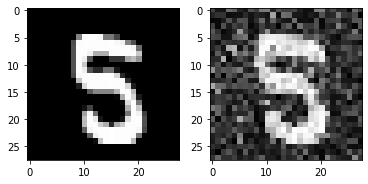

25  :  0.6564826848530028 25
50  :  0.6564826848530028 25
75  :  0.6564826848530028 25
100  :  0.6564826848530028 25
125  :  0.6564826848530028 25
150  :  0.6564826848530028 25
175  :  0.6564826848530028 25
200  :  0.6616753889089564 25
225  :  0.6612230333999618 25
250  :  0.6612230333999618 25
275  :  0.6612230333999618 25
300  :  0.6612230333999618 25
325  :  0.6656623483403912 25
350  :  0.6657109463536907 25
375  :  0.666277982868527 25
400  :  0.6662668392089864 25
425  :  0.6678537947839346 25
450  :  0.6678537947839346 25
475  :  0.6720147389478304 25
500  :  0.6715159602136902 25
525  :  0.6715159602136902 25
550  :  0.6749021091925586 25
575  :  0.6773721390972218 25
600  :  0.6773107693456657 25
625  :  0.6773107693456657 25
650  :  0.6777798187941795 25
675  :  0.677877385178907 25
700  :  0.6806124268595425 25
725  :  0.6808963414955745 25
750  :  0.6818609512363262 25
775  :  0.6820934829854799 25
800  :  0.6828149417511815 25
Time:  45.58319592475891  seconds
Predicted c

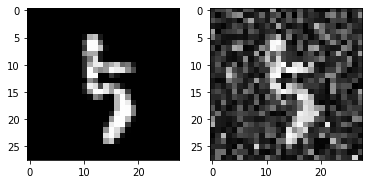

25  :  0.7383834583333335 25
50  :  0.7383834583333335 25
75  :  0.7397707416899002 25
100  :  0.740652914906857 25
125  :  0.743710470429549 25
150  :  0.7479909043521955 25
175  :  0.7489160516394242 25
200  :  0.7526528887701636 25
225  :  0.7530438810547281 25
250  :  0.7530438810547281 25
275  :  0.7544536518000491 25
300  :  0.7605119982471258 25
325  :  0.7660566511450877 25
350  :  0.7660566511450877 25
375  :  0.7660566511450877 25
400  :  0.7660566511450877 25
425  :  0.7692416324065985 25
450  :  0.7692316652329283 25
475  :  0.7711552648652678 25
500  :  0.7711350495593947 25
525  :  0.7716109414985953 25
550  :  0.772638629637212 25
575  :  0.7735149743189438 25
600  :  0.7738728686517864 25
625  :  0.7738728686517864 25
650  :  0.7744474072188412 25
675  :  0.7745819087915239 25
700  :  0.7752109377858134 25
725  :  0.7752801536156024 25
750  :  0.7764184771479414 25
775  :  0.7764163571286852 25
800  :  0.7768579470063373 25
Time:  44.90112566947937  seconds
Predicted cl

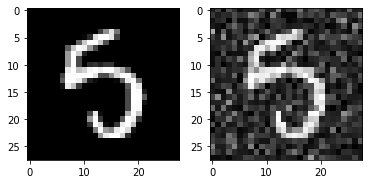

25  :  0.7700140922914479 25
50  :  0.7700140922914479 25
75  :  0.7938100244310228 25
100  :  0.7944128578344576 25
125  :  0.7944128578344576 25
150  :  0.7944128578344576 25
175  :  0.7944128578344576 25
200  :  0.7944128578344576 25
225  :  0.7944128578344576 25
250  :  0.7944128578344576 25
275  :  0.7944128578344576 25
300  :  0.7947175272548876 25
325  :  0.8052983191951095 25
350  :  0.8052983191951095 25
375  :  0.8052983191951095 25
400  :  0.8091318849813588 25
425  :  0.8091001243856748 25
450  :  0.8091001243856748 25
475  :  0.8091001243856748 25
500  :  0.8091001243856748 25
525  :  0.811475059614612 25
550  :  0.8136137928099657 25
575  :  0.8142671516421216 25
600  :  0.8153959552531627 25
625  :  0.8154851168947521 25
650  :  0.8163718568792624 25
675  :  0.8170730231664569 25
700  :  0.817912820166458 25
725  :  0.8186674455961802 25
750  :  0.8192809534113552 25
775  :  0.8198521947513826 25
800  :  0.8198521947513826 25
825  :  0.8198521947513826 25
850  :  0.81985

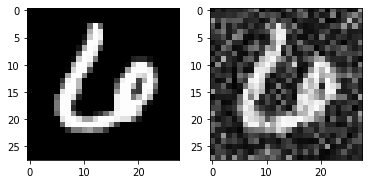

25  :  0.6062265625728586 25
50  :  0.6968591777542152 25
75  :  0.725765231327846 25
100  :  0.7248343993830904 25
125  :  0.7248343993830904 25
150  :  0.7248343993830904 25
175  :  0.7248343993830904 25
200  :  0.7248343993830904 25
225  :  0.7248343993830904 25
250  :  0.7248343993830904 25
275  :  0.7259029070239447 25
300  :  0.7279384699074911 25
325  :  0.7279384699074911 25
350  :  0.7335320772170352 25
375  :  0.7363243545371901 25
400  :  0.7365000841612268 25
425  :  0.7368014125138129 25
450  :  0.7420511502978357 25
475  :  0.7420511502978357 25
500  :  0.746070290423032 25
525  :  0.7460602971591213 25
550  :  0.7488427836942864 25
575  :  0.7484948812800584 25
600  :  0.7490407979892497 25
625  :  0.7502039322264282 25
650  :  0.7518793728380385 25
675  :  0.7528203295533501 25
700  :  0.7524093266205157 25
725  :  0.7549296300398303 25
750  :  0.7567193271101733 25
775  :  0.7564744488594268 25
800  :  0.7591573576578088 25
825  :  0.759160573333765 25
850  :  0.762873

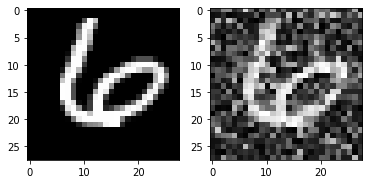

25  :  0.4006829941582779 25
50  :  0.49132221570995227 25
75  :  0.672328248668092 25
100  :  0.6786882034462147 25
125  :  0.6842145266380366 25
150  :  0.6795655573910448 25
175  :  0.6814852197552386 25
200  :  0.6814852197552386 25
225  :  0.6814852197552386 25
250  :  0.6814852197552386 25
275  :  0.6814852197552386 25
300  :  0.6818214308218044 25
325  :  0.6818214308218044 25
350  :  0.6939329531870406 25
375  :  0.6937593888534603 25
400  :  0.6937593888534603 25
425  :  0.6937593888534603 25
450  :  0.6948941653009195 25
475  :  0.6969269001180652 25
500  :  0.6969269001180652 25
525  :  0.6969269001180652 25
550  :  0.6991808639567028 25
575  :  0.6991808639567028 25
600  :  0.6991808639567028 25
625  :  0.6991808639567028 25
650  :  0.6997347220149577 25
675  :  0.6997347220149577 25
700  :  0.7010159053212401 25
725  :  0.7010159053212401 25
750  :  0.7018611458933013 25
775  :  0.7018711623035794 25
800  :  0.702235608135583 25
825  :  0.702235921513118 25
850  :  0.70388

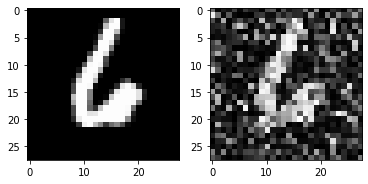

25  :  0.7453033364456223 25
50  :  0.7453033364456223 25
75  :  0.7453033364456223 25
100  :  0.7453033364456223 25
125  :  0.7453033364456223 25
150  :  0.7487099607919162 25
175  :  0.7492379629159795 25
200  :  0.7513377016007399 25
225  :  0.7513377016007399 25
250  :  0.7513377016007399 25
275  :  0.7559338416757679 25
300  :  0.7572750389233398 25
325  :  0.7610661361096143 25
350  :  0.7624060184784567 25
375  :  0.7621826926564976 25
400  :  0.7621826926564976 25
425  :  0.7621826926564976 25
450  :  0.7676053574846325 25
475  :  0.768377381753371 25
500  :  0.768377381753371 25
525  :  0.768377381753371 25
550  :  0.768377381753371 25
575  :  0.768377381753371 25
600  :  0.7698146049626331 25
625  :  0.769796814255348 25
650  :  0.7708587695583484 25
675  :  0.7713049365507612 25
700  :  0.7741213685869086 25
725  :  0.7741213685869086 25
750  :  0.7741213685869086 25
775  :  0.7741213685869086 25
800  :  0.7741213685869086 25
Time:  44.804190158843994  seconds
Predicted clas

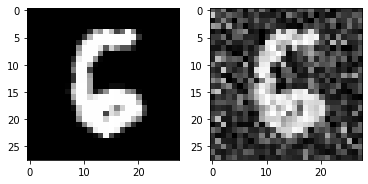

25  :  0.7270841548504381 25
50  :  0.7270841548504381 25
75  :  0.7186264434305072 25
100  :  0.7128602710880944 25
125  :  0.7160058468244674 25
150  :  0.7253753978920972 25
175  :  0.7253753978920972 25
200  :  0.7253753978920972 25
225  :  0.7253753978920972 25
250  :  0.7253753978920972 25
275  :  0.7253753978920972 25
300  :  0.7253753978920972 25
325  :  0.7253753978920972 25
350  :  0.7259397147514015 25
375  :  0.7354252855836458 25
400  :  0.7362679791059918 25
425  :  0.7362679791059918 25
450  :  0.7362679791059918 25
475  :  0.7362679791059918 25
500  :  0.7376792123361081 25
525  :  0.7379141740296007 25
550  :  0.7379141740296007 25
575  :  0.7379141740296007 25
600  :  0.7379141740296007 25
625  :  0.7439238279567957 25
650  :  0.7439238279567957 25
675  :  0.7439238279567957 25
700  :  0.7439238279567957 25
725  :  0.7440621416365664 25
750  :  0.7439238279567957 25
775  :  0.7442023900102528 25
800  :  0.7462426118289859 25
Time:  48.74017643928528  seconds
Predicted

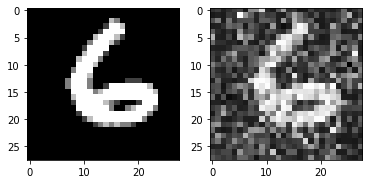

25  :  0.777870303442183 25
50  :  0.777870303442183 25
75  :  0.777870303442183 25
100  :  0.7843311090068973 25
125  :  0.7854785233912975 25
150  :  0.7854785233912975 25
175  :  0.7854785233912975 25
200  :  0.7854785233912975 25
225  :  0.7854785233912975 25
250  :  0.7854785233912975 25
275  :  0.7854785233912975 25
300  :  0.7854785233912975 25
325  :  0.7896875511211097 25
350  :  0.7896875511211097 25
375  :  0.7896875511211097 25
400  :  0.7896875511211097 25
425  :  0.7896875511211097 25
450  :  0.7896875511211097 25
475  :  0.7896875511211097 25
500  :  0.7896875511211097 25
525  :  0.7896875511211097 25
550  :  0.7896875511211097 25
575  :  0.7896875511211097 25
600  :  0.7896875511211097 25
625  :  0.7896875511211097 25
650  :  0.7896875511211097 25
675  :  0.7896875511211097 25
700  :  0.7896875511211097 25
725  :  0.7896875511211097 25
750  :  0.7896875511211097 25
775  :  0.7896875511211097 25
800  :  0.7896875511211097 25
Time:  44.537904024124146  seconds
Predicted c

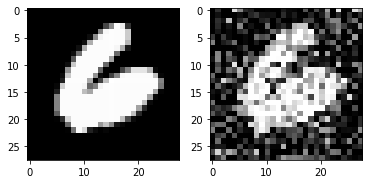

25  :  0.7839322520432785 25
50  :  0.7839322520432785 25
75  :  0.7863285944690315 25
100  :  0.7863285944690315 25
125  :  0.7901149100430636 25
150  :  0.7894917343083934 25
175  :  0.7961813054919175 25
200  :  0.7959829235766687 25
225  :  0.7959829235766687 25
250  :  0.7959829235766687 25
275  :  0.7965614323370811 25
300  :  0.8041922561651411 25
325  :  0.8041922561651411 25
350  :  0.8041922561651411 25
375  :  0.8041922561651411 25
400  :  0.8041922561651411 25
425  :  0.8111223125307245 25
450  :  0.8139176523120041 25
475  :  0.8140319142483975 25
500  :  0.8148049667485614 25
525  :  0.8148497435554724 25
550  :  0.8165484132410288 25
575  :  0.8189175445688577 25
600  :  0.8189175445688577 25
625  :  0.8190736005459662 25
650  :  0.819575406179826 25
675  :  0.8196082870992827 25
700  :  0.8213778938541432 25
725  :  0.8213778938541432 25
750  :  0.8215835647101966 25
775  :  0.8215835647101966 25
800  :  0.8215835647101966 25
Time:  45.022690296173096  seconds
Predicted

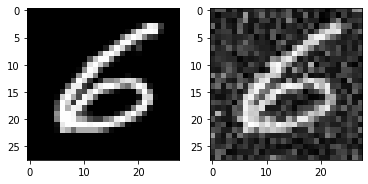

25  :  0.7489413418664941 25
50  :  0.7489413418664941 25
75  :  0.7490866036447802 25
100  :  0.7497716587196726 25
125  :  0.7639816239460337 25
150  :  0.7639816239460337 25
175  :  0.7639816239460337 25
200  :  0.7639816239460337 25
225  :  0.7639816239460337 25
250  :  0.7656072865259579 25
275  :  0.7665638807686241 25
300  :  0.7730966277281659 25
325  :  0.7730966277281659 25
350  :  0.7730966277281659 25
375  :  0.775141634552003 25
400  :  0.7751502772254955 25
425  :  0.7752609499699851 25
450  :  0.7759615446639503 25
475  :  0.7761907328786783 25
500  :  0.7780730820660631 25
525  :  0.7780730820660631 25
550  :  0.7780730820660631 25
575  :  0.7780730820660631 25
600  :  0.7786688403270522 25
625  :  0.7788083786502552 25
650  :  0.7790074946191611 25
675  :  0.7791600105552414 25
700  :  0.7792771711902956 25
725  :  0.779358068055509 25
750  :  0.7797611736248323 25
775  :  0.7797610544155428 25
800  :  0.7797610544155428 25
825  :  0.7797610544155428 25
850  :  0.77982

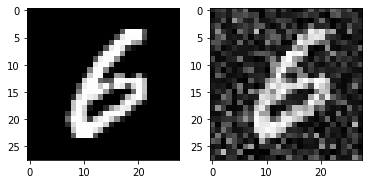

25  :  0.6095169432703003 25
50  :  0.6517183291189588 25
75  :  0.6732789662056686 25
100  :  0.6780624570009944 25
125  :  0.6872175219693065 25
150  :  0.6863628685048442 25
175  :  0.6863628685048442 25
200  :  0.6863628685048442 25
225  :  0.6866239633630556 25
250  :  0.6865835845804136 25
275  :  0.6865835845804136 25
300  :  0.6865835845804136 25
325  :  0.6896044879526386 25
350  :  0.6886630674339026 25
375  :  0.6886630674339026 25
400  :  0.6934463018221168 25
425  :  0.6928175624913085 25
450  :  0.6925998699530436 25
475  :  0.6972428202647855 25
500  :  0.69759007724266 25
525  :  0.6986830115090855 25
550  :  0.6992835701124253 25
575  :  0.6992446677695873 25
600  :  0.70242217829782 25
625  :  0.7032782732460763 25
650  :  0.7032782732460763 25
675  :  0.7032782732460763 25
700  :  0.7032782732460763 25
725  :  0.70695127103147 25
750  :  0.7069050967165453 25
775  :  0.7087131429114931 25
800  :  0.7086076648287288 25
825  :  0.7087750929454333 25
850  :  0.708721273

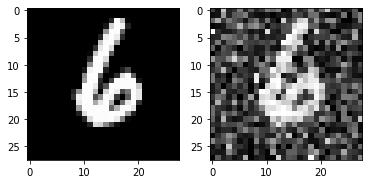

25  :  0.6806894395992183 25
50  :  0.6864515661962446 25
75  :  0.6906868229687095 25
100  :  0.6989713350290876 25
125  :  0.6989713350290876 25
150  :  0.6989713350290876 25
175  :  0.6989713350290876 25
200  :  0.6989713350290876 25
225  :  0.7057519243101799 25
250  :  0.7067769634692795 25
275  :  0.7067769634692795 25
300  :  0.7067769634692795 25
325  :  0.7122738563662747 25
350  :  0.7122738563662747 25
375  :  0.7122738563662747 25
400  :  0.7122738563662747 25
425  :  0.7122738563662747 25
450  :  0.7143225937599906 25
475  :  0.7143205581673535 25
500  :  0.7174975333539232 25
525  :  0.7174653468754371 25
550  :  0.7220888888416285 25
575  :  0.7235035831157557 25
600  :  0.7237148268300468 25
625  :  0.7240202793779463 25
650  :  0.7248997446032108 25
675  :  0.7260334414292993 25
700  :  0.7260949598676119 25
725  :  0.7267212035961238 25
750  :  0.7271955475798666 25
775  :  0.7277999484125226 25
800  :  0.7277999484125226 25
Time:  45.19759678840637  seconds
Predicted

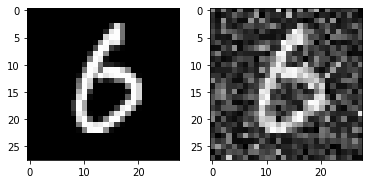

25  :  0.678714630227404 25
50  :  0.7063685054393669 25
75  :  0.7043539042946579 25
100  :  0.7087460301612138 25
125  :  0.7059796190006793 25
150  :  0.7059796190006793 25
175  :  0.7090280812059128 25
200  :  0.7073596840503218 25
225  :  0.7086460777331701 25
250  :  0.7142504243814387 25
275  :  0.7126950815505739 25
300  :  0.7126950815505739 25
325  :  0.719281508158126 25
350  :  0.7189314283997384 25
375  :  0.7189314283997384 25
400  :  0.7189314283997384 25
425  :  0.7192398926598762 25
450  :  0.7192418006362873 25
475  :  0.7249619530077761 25
500  :  0.7257152495828129 25
525  :  0.7255660316349857 25
550  :  0.7255660316349857 25
575  :  0.7255660316349857 25
600  :  0.7269520602809834 25
625  :  0.7295271468316504 25
650  :  0.7294657625971883 25
675  :  0.7294657625971883 25
700  :  0.7294657625971883 25
725  :  0.7305596883922433 25
750  :  0.7309284035047715 25
775  :  0.7318245317115502 25
800  :  0.7325771922673916 25
825  :  0.7332339576536233 25
Time:  47.15205

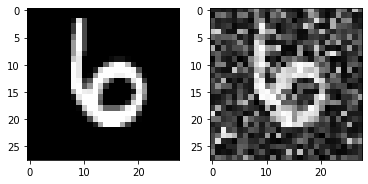

25  :  0.6980944584839013 25
50  :  0.7117641245980797 25
75  :  0.6987186703673786 25
100  :  0.703383605664363 25
125  :  0.7073264263385685 25
150  :  0.7073264263385685 25
175  :  0.7073264263385685 25
200  :  0.7073264263385685 25
225  :  0.7073264263385685 25
250  :  0.7095257001928904 25
275  :  0.7096933242793515 25
300  :  0.7082614880603155 25
325  :  0.7139774466286652 25
350  :  0.7126083110867155 25
375  :  0.7151247294286978 25
400  :  0.7179305672222848 25
425  :  0.718047099986445 25
450  :  0.7181161658029018 25
475  :  0.7208469317397045 25
500  :  0.7240346489509046 25
525  :  0.7255132136467873 25
550  :  0.7269500948441302 25
575  :  0.7269500948441302 25
600  :  0.7269500948441302 25
625  :  0.7269500948441302 25
650  :  0.72787988013192 25
675  :  0.72787988013192 25
700  :  0.728160526389982 25
725  :  0.7305502657279557 25
750  :  0.7305405665361215 25
775  :  0.7311251660660959 25
800  :  0.7320620603122352 25
825  :  0.7331161791248947 25
850  :  0.7331161791

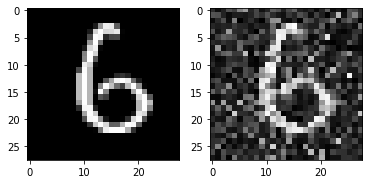

25  :  0.6872417730807253 25
50  :  0.6872417730807253 25
75  :  0.6872417730807253 25
100  :  0.6872417730807253 25
125  :  0.6872417730807253 25
150  :  0.6872417730807253 25
175  :  0.6872417730807253 25
200  :  0.6872417730807253 25
225  :  0.6872417730807253 25
250  :  0.6872417730807253 25
275  :  0.6929329636687587 25
300  :  0.6929329636687587 25
325  :  0.6929329636687587 25
350  :  0.6929329636687587 25
375  :  0.6929329636687587 25
400  :  0.6929329636687587 25
425  :  0.6929329636687587 25
450  :  0.6929329636687587 25
475  :  0.6929329636687587 25
500  :  0.6929329636687587 25
525  :  0.6929329636687587 25
550  :  0.6929329636687587 25
575  :  0.6929329636687587 25
600  :  0.6929329636687587 25
625  :  0.6929329636687587 25
650  :  0.6929329636687587 25
675  :  0.6929329636687587 25
700  :  0.6929329636687587 25
725  :  0.6929329636687587 25
750  :  0.6929329636687587 25
775  :  0.6929329636687587 25
800  :  0.6929329636687587 25
Time:  45.320014238357544  seconds
Predicte

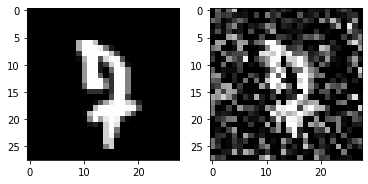

25  :  0.8226580386471576 25
50  :  0.8261133932758156 25
75  :  0.827041285201046 25
100  :  0.827041285201046 25
125  :  0.827041285201046 25
150  :  0.8275329413839602 25
175  :  0.8352962363353131 25
200  :  0.8355727529650642 25
225  :  0.841324393350217 25
250  :  0.8419065566363635 25
275  :  0.8419065566363635 25
300  :  0.8441162716120038 25
325  :  0.8438844941994957 25
350  :  0.8460667339807268 25
375  :  0.8475899082752052 25
400  :  0.8480614216967197 25
425  :  0.8477765791642777 25
450  :  0.8552956624950606 25
475  :  0.8550689026253637 25
500  :  0.8586007899594046 25
525  :  0.8598419705985765 25
550  :  0.859721739077334 25
575  :  0.8610546382609803 25
600  :  0.8610546382609803 25
625  :  0.8611142942221004 25
650  :  0.8621943526855125 25
675  :  0.8621801843353862 25
700  :  0.8626494103293787 25
725  :  0.8637945813764427 25
750  :  0.8637945813764427 25
775  :  0.8641058860014175 25
800  :  0.8641915584492097 25
Time:  45.2587788105011  seconds
Predicted class

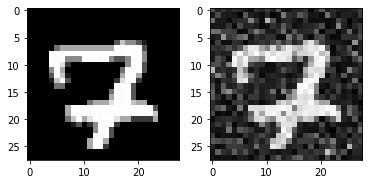

25  :  0.707904518456085 25
50  :  0.7127390576707279 25
75  :  0.7039473003297492 25
100  :  0.7065992506658492 25
125  :  0.7065992506658492 25
150  :  0.7065992506658492 25
175  :  0.7065992506658492 25
200  :  0.7065992506658492 25
225  :  0.7065992506658492 25
250  :  0.7075119299237618 25
275  :  0.7117793832011114 25
300  :  0.7122490701921063 25
325  :  0.7133661540011832 25
350  :  0.7131477699397212 25
375  :  0.7163901070441441 25
400  :  0.7163901070441441 25
425  :  0.7196212877377308 25
450  :  0.7165455650514966 25
475  :  0.7174173374845126 25
500  :  0.7185858343812973 25
525  :  0.7188748445715389 25
550  :  0.7205118357430507 25
575  :  0.7206147025597335 25
600  :  0.7206147025597335 25
625  :  0.7217421951588494 25
650  :  0.7235261143079822 25
675  :  0.7234897347267477 25
700  :  0.7234897347267477 25
725  :  0.7245467396215851 25
750  :  0.7248248493095437 25
775  :  0.7248248493095437 25
800  :  0.7263496923519195 25
Time:  45.425875186920166  seconds
Predicted

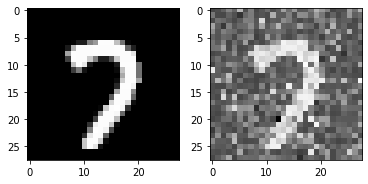

25  :  0.016018591120237402 25
50  :  0.639761242510744 25
75  :  0.5540371617886833 25
100  :  0.6781440433644378 25
125  :  0.6829645716690833 25
150  :  0.6829645716690833 25
175  :  0.6829645716690833 25
200  :  0.6829645716690833 25
225  :  0.6861241533954616 25
250  :  0.6829645716690833 25
275  :  0.6829645716690833 25
300  :  0.6860059958951381 25
325  :  0.6875636511470987 25
350  :  0.6886931162638901 25
375  :  0.6884319690952765 25
400  :  0.6884319690952765 25
425  :  0.6884319690952765 25
450  :  0.6884319690952765 25
475  :  0.691411253429171 25
500  :  0.6918922221628576 25
525  :  0.6918922221628576 25
550  :  0.6918922221628576 25
575  :  0.6918922221628576 25
600  :  0.6944987125770603 25
625  :  0.6983101719118328 25
650  :  0.6981949569795062 25
675  :  0.701568466467505 25
700  :  0.7015254680537979 25
725  :  0.7017371060015455 25
750  :  0.7018478050417589 25
775  :  0.7023685215112567 25
800  :  0.7033260273302332 25
825  :  0.7033260273302332 25
850  :  0.7048

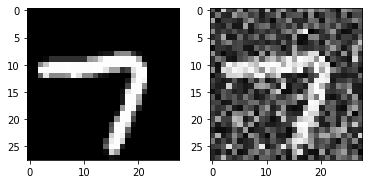

25  :  0.6564036321729069 25
50  :  0.6632091889875414 25
75  :  0.7006459636576974 25
100  :  0.7006459636576974 25
125  :  0.7186006537218426 25
150  :  0.7186006537218426 25
175  :  0.7186006537218426 25
200  :  0.7186006537218426 25
225  :  0.7186006537218426 25
250  :  0.7186006537218426 25
275  :  0.7186006537218426 25
300  :  0.7186006537218426 25
325  :  0.7186006537218426 25
350  :  0.7232692173627532 25
375  :  0.7240588238299681 25
400  :  0.724268607920872 25
425  :  0.724268607920872 25
450  :  0.724268607920872 25
475  :  0.7273819013623735 25
500  :  0.7273819013623735 25
525  :  0.7273819013623735 25
550  :  0.7273819013623735 25
575  :  0.7282264885366982 25
600  :  0.7281356817343538 25
625  :  0.7281356817343538 25
650  :  0.7281356817343538 25
675  :  0.7281980098976573 25
700  :  0.7289677079926602 25
725  :  0.7304395448956937 25
750  :  0.7304342436370148 25
775  :  0.7323485013543027 25
800  :  0.7323374674951455 25
825  :  0.7323374674951455 25
850  :  0.732812

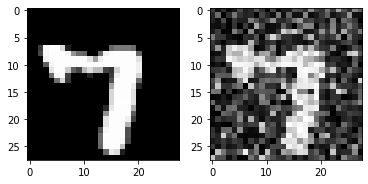

25  :  0.6312692499563974 25
50  :  0.6360435753270821 25
75  :  0.6359365919617439 25
100  :  0.6423752674490284 25
125  :  0.642377942556319 25
150  :  0.642377942556319 25
175  :  0.6430713111650772 25
200  :  0.6427738773351913 25
225  :  0.6427738773351913 25
250  :  0.642859843521026 25
275  :  0.6450656319348447 25
300  :  0.6460548328317894 25
325  :  0.6473624551781242 25
350  :  0.648681433862722 25
375  :  0.6512554853251631 25
400  :  0.6512564359239451 25
425  :  0.6521017373048174 25
450  :  0.6519513673026639 25
475  :  0.6549413702385638 25
500  :  0.655381064513872 25
525  :  0.658095466801163 25
550  :  0.6583385508859939 25
575  :  0.658310210432032 25
600  :  0.6589306225778686 25
625  :  0.6595937162388579 25
650  :  0.6595937162388579 25
675  :  0.6604145823392693 25
700  :  0.6612948691076015 25
725  :  0.6613549526869775 25
750  :  0.661345079693401 25
775  :  0.6619634672000708 25
800  :  0.6627101381698517 25
Time:  45.13171172142029  seconds
Predicted class: 

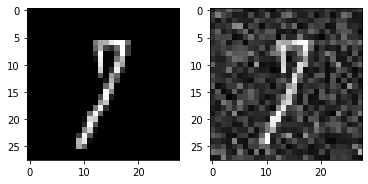

25  :  0.7254824688279807 25
50  :  0.7358668275641685 25
75  :  0.7287837309030194 25
100  :  0.7287537153425891 25
125  :  0.7269521987733146 25
150  :  0.7336622758697532 25
175  :  0.7323696528457992 25
200  :  0.7323960505780647 25
225  :  0.7323960505780647 25
250  :  0.7323960505780647 25
275  :  0.7323960505780647 25
300  :  0.7323960505780647 25
325  :  0.7323960505780647 25
350  :  0.7343167627370898 25
375  :  0.7341318844178758 25
400  :  0.7378582883270665 25
425  :  0.7378582883270665 25
450  :  0.7385380663249635 25
475  :  0.7369802641023888 25
500  :  0.7369802641023888 25
525  :  0.7390322398281802 25
550  :  0.7430383016724171 25
575  :  0.7430383016724171 25
600  :  0.7430383016724171 25
625  :  0.7430383016724171 25
650  :  0.7430383016724171 25
675  :  0.7430383016724171 25
700  :  0.7440960651362356 25
725  :  0.7440073714875498 25
750  :  0.7440073714875498 25
775  :  0.7440073714875498 25
800  :  0.7443075470266558 25
825  :  0.7443075470266558 25
Time:  45.980

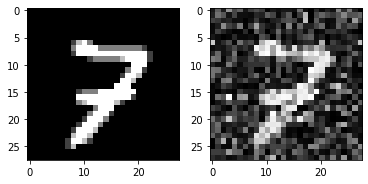

25  :  0.7418922578423699 25
50  :  0.7418922578423699 25
75  :  0.7418922578423699 25
100  :  0.7418922578423699 25
125  :  0.7418922578423699 25
150  :  0.7418922578423699 25
175  :  0.7418922578423699 25
200  :  0.7418922578423699 25
225  :  0.7418922578423699 25
250  :  0.7418922578423699 25
275  :  0.7418922578423699 25
300  :  0.7418922578423699 25
325  :  0.7418922578423699 25
350  :  0.744042437134662 25
375  :  0.744042437134662 25
400  :  0.7479424665493432 25
425  :  0.7479053110085386 25
450  :  0.7479053110085386 25
475  :  0.748248959606917 25
500  :  0.749246070612773 25
525  :  0.7492846362899725 25
550  :  0.7523976531603622 25
575  :  0.7533550395663071 25
600  :  0.7533550395663071 25
625  :  0.7533550395663071 25
650  :  0.7533550395663071 25
675  :  0.7554280463252981 25
700  :  0.7559744982409282 25
725  :  0.7559744982409282 25
750  :  0.7559744982409282 25
775  :  0.756892263471151 25
800  :  0.7568931960016985 25
Time:  45.063639879226685  seconds
Predicted cla

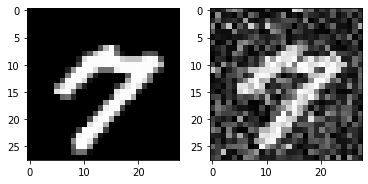

25  :  0.7037356474709175 25
50  :  0.7037356474709175 25
75  :  0.7037356474709175 25
100  :  0.7037356474709175 25
125  :  0.7037356474709175 25
150  :  0.7037356474709175 25
175  :  0.7037356474709175 25
200  :  0.7037356474709175 25
225  :  0.7037356474709175 25
250  :  0.7055354590208845 25
275  :  0.708895767648442 25
300  :  0.7088912652862092 25
325  :  0.7088912652862092 25
350  :  0.7088912652862092 25
375  :  0.7088912652862092 25
400  :  0.7109615141294188 25
425  :  0.7125326348816072 25
450  :  0.7125326348816072 25
475  :  0.7125326348816072 25
500  :  0.7125326348816072 25
525  :  0.7125326348816072 25
550  :  0.7125326348816072 25
575  :  0.7125326348816072 25
600  :  0.7125326348816072 25
625  :  0.7125326348816072 25
650  :  0.7137768929380268 25
675  :  0.7164895656240882 25
700  :  0.7164895656240882 25
725  :  0.7164895656240882 25
750  :  0.7177371258500331 25
775  :  0.7183662595466787 25
800  :  0.7183683029766255 25
Time:  44.74796271324158  seconds
Predicted 

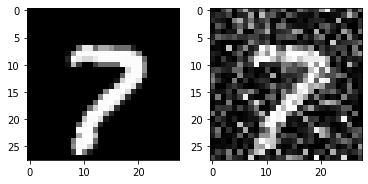

25  :  0.6900949424228183 25
50  :  0.6900949424228183 25
75  :  0.6900949424228183 25
100  :  0.6900949424228183 25
125  :  0.6900949424228183 25
150  :  0.6900949424228183 25
175  :  0.6900949424228183 25
200  :  0.6900949424228183 25
225  :  0.6900949424228183 25
250  :  0.6900949424228183 25
275  :  0.6900949424228183 25
300  :  0.6900949424228183 25
325  :  0.6900949424228183 25
350  :  0.6937533296074412 25
375  :  0.6926942927853703 25
400  :  0.6926942927853703 25
425  :  0.6926942927853703 25
450  :  0.6926942927853703 25
475  :  0.6926942927853703 25
500  :  0.6926942927853703 25
525  :  0.6926942927853703 25
550  :  0.6926942927853703 25
575  :  0.6926942927853703 25
600  :  0.6926942927853703 25
625  :  0.6942638519878841 25
650  :  0.6944879736553949 25
675  :  0.6944879736553949 25
700  :  0.6944879736553949 25
725  :  0.6944879736553949 25
750  :  0.6983222678915115 25
775  :  0.6983222678915115 25
800  :  0.699038772236545 25
Time:  44.84636402130127  seconds
Predicted 

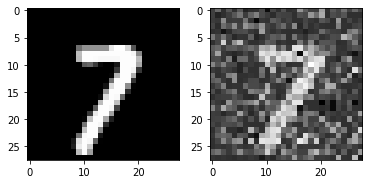

25  :  0.6643222765161144 25
50  :  0.6643222765161144 25
75  :  0.664782884950831 25
100  :  0.664782884950831 25
125  :  0.6702710578931991 25
150  :  0.6683486849787788 25
175  :  0.6696623973194632 25
200  :  0.6715424279723023 25
225  :  0.6726605490815978 25
250  :  0.6732959856719919 25
275  :  0.674125830363268 25
300  :  0.6741638420190041 25
325  :  0.6741638420190041 25
350  :  0.6741638420190041 25
375  :  0.6774139430352679 25
400  :  0.6785660609422279 25
425  :  0.6785660609422279 25
450  :  0.6785660609422279 25
475  :  0.6797924666820725 25
500  :  0.6797924666820725 25
525  :  0.6803287331172215 25
550  :  0.6803280127750378 25
575  :  0.6824432703023722 25
600  :  0.6832743150379967 25
625  :  0.6829302115496371 25
650  :  0.6833696161606349 25
675  :  0.6833471470962919 25
700  :  0.6842151113657837 25
725  :  0.6840432188463557 25
750  :  0.6846201418622815 25
775  :  0.6871583079062271 25
800  :  0.6871614837014506 25
Time:  44.80782389640808  seconds
Predicted cl

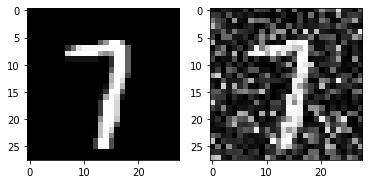

25  :  0.6401013346379025 25
50  :  0.6498602325496206 25
75  :  0.6454042856260941 25
100  :  0.6454042856260941 25
125  :  0.6473140961116348 25
150  :  0.6533023403785561 25
175  :  0.6533023403785561 25
200  :  0.6533023403785561 25
225  :  0.6533023403785561 25
250  :  0.6533023403785561 25
275  :  0.6533023403785561 25
300  :  0.6533023403785561 25
325  :  0.6598413711222274 25
350  :  0.6608976396672432 25
375  :  0.6633312583149847 25
400  :  0.6649549697744106 25
425  :  0.6649870576442803 25
450  :  0.6661741399361051 25
475  :  0.6659682965615555 25
500  :  0.6678055323702583 25
525  :  0.667634734028922 25
550  :  0.6677961654683559 25
575  :  0.6677961654683559 25
600  :  0.6684257172502848 25
625  :  0.6687776711180143 25
650  :  0.6687776711180143 25
675  :  0.6687776711180143 25
700  :  0.6709264074238959 25
725  :  0.6708247796450825 25
750  :  0.6708247796450825 25
775  :  0.6733455350152185 25
800  :  0.673250157397077 25
Time:  44.707274436950684  seconds
Predicted 

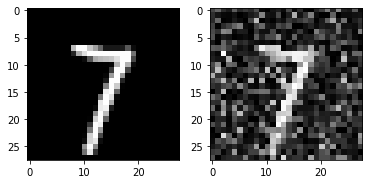

25  :  0.629069355321334 25
50  :  0.629069355321334 25
75  :  0.629069355321334 25
100  :  0.629069355321334 25
125  :  0.629069355321334 25
150  :  0.629069355321334 25
175  :  0.629069355321334 25
200  :  0.629069355321334 25
225  :  0.629069355321334 25
250  :  0.629069355321334 25
275  :  0.6295044273050656 25
300  :  0.6365640850231937 25
325  :  0.6324620017021771 25
350  :  0.6324620017021771 25
375  :  0.6372359922874571 25
400  :  0.6385483844166102 25
425  :  0.6444608380915644 25
450  :  0.6444608380915644 25
475  :  0.6444608380915644 25
500  :  0.6444608380915644 25
525  :  0.6473567662037597 25
550  :  0.6473376346295514 25
575  :  0.6474618358425983 25
600  :  0.6474618358425983 25
625  :  0.6489659721820802 25
650  :  0.6489659721820802 25
675  :  0.6489659721820802 25
700  :  0.6489659721820802 25
725  :  0.6493269609614132 25
750  :  0.6499066016710235 25
775  :  0.6499066016710235 25
800  :  0.6499066016710235 25
Time:  45.05589032173157  seconds
Predicted class:  [

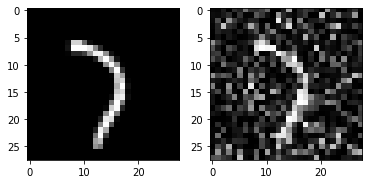

25  :  -0.28532066876724216 25
50  :  -0.27020774367219347 25
75  :  -0.27033716436813604 25
100  :  -0.27033716436813604 25
125  :  -0.2679673880637518 25
150  :  -0.2680835073434988 25
175  :  -0.2640439763986874 25
200  :  -0.25985654928886603 25
225  :  -0.25990455969596415 25
250  :  -0.25990455969596415 25
275  :  -0.2580967821422838 25
300  :  -0.2577655437693851 25
325  :  -0.2570430875262243 25
350  :  -0.254947916588144 25
375  :  -0.25240817966531354 25
400  :  -0.2520398241285797 25
425  :  -0.2519414030105813 25
450  :  -0.2519411438180447 25
475  :  -0.2519411438180447 25
500  :  -0.2519411438180447 25
525  :  -0.2517103994696329 25
550  :  -0.2508877800590506 25
575  :  -0.2508877800590506 25
600  :  -0.2508531942250251 25
625  :  -0.25080816569116027 25
650  :  -0.24998388673159616 25
675  :  -0.24984395696808387 25
700  :  -0.24945341133489424 25
725  :  -0.24945341133489424 25
750  :  -0.24898310610699542 25
775  :  -0.24878796208150716 25
800  :  -0.24817302496126775

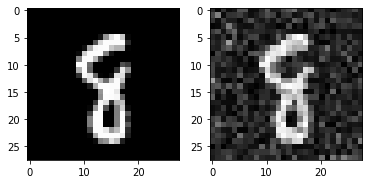

25  :  -0.2580496194579097 25
50  :  -0.24165461533217897 25
75  :  -0.23985798875147873 25
100  :  -0.23954608976836095 25
125  :  -0.23855619577305748 25
150  :  -0.23673405770324574 25
175  :  -0.23653986373308133 25
200  :  -0.2334765047535528 25
225  :  -0.23303890762407375 25
250  :  -0.2286825603599662 25
275  :  -0.22738386133588995 25
300  :  -0.2253140742655197 25
325  :  -0.22225493337983582 25
350  :  -0.22225493337983582 25
375  :  -0.22225493337983582 25
400  :  -0.22225493337983582 25
425  :  -0.22225493337983582 25
450  :  -0.22089182963689458 25
475  :  -0.22089182963689458 25
500  :  -0.22089182963689458 25
525  :  -0.220192358822501 25
550  :  -0.21935191552753142 25
575  :  -0.21935191552753142 25
600  :  -0.21880661293023906 25
625  :  -0.21880679568243 25
650  :  -0.21880679568243 25
675  :  -0.21870271198309665 25
700  :  -0.2185513266765014 25
725  :  -0.21849370018001657 25
750  :  -0.21826577583867718 25
775  :  -0.21749054114366256 25
800  :  -0.2174978419908

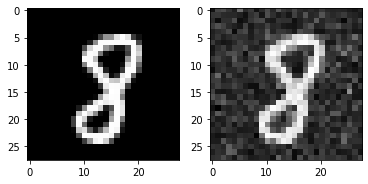

25  :  -0.2280302527136263 25
50  :  -0.2280302527136263 25
75  :  -0.21931417245124768 25
100  :  -0.21445698886844677 25
125  :  -0.21335471286200924 25
150  :  -0.20849933566711343 25
175  :  -0.20703316754134915 25
200  :  -0.20120806758109328 25
225  :  -0.20120806758109328 25
250  :  -0.20080372463637086 25
275  :  -0.19939110642789165 25
300  :  -0.19855832649197985 25
325  :  -0.19710178381033883 25
350  :  -0.19535878445066174 25
375  :  -0.1953597248061567 25
400  :  -0.19346701174839936 25
425  :  -0.19157649420827444 25
450  :  -0.19066960162096958 25
475  :  -0.19066960162096958 25
500  :  -0.19066960162096958 25
525  :  -0.19044732713660006 25
550  :  -0.19044732713660006 25
575  :  -0.19031341715687633 25
600  :  -0.19010010679763123 25
625  :  -0.1894324655720705 25
650  :  -0.18893525508782855 25
675  :  -0.18893525508782855 25
700  :  -0.18893525508782855 25
725  :  -0.18893525508782855 25
750  :  -0.18885089026773616 25
775  :  -0.1887594366111195 25
800  :  -0.18857

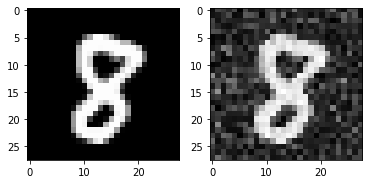

25  :  -0.2286027032416379 25
50  :  -0.22682983198510304 25
75  :  -0.2244960878397051 25
100  :  -0.2244960878397051 25
125  :  -0.22142403459521037 25
150  :  -0.20768895876597954 25
175  :  -0.20621520725337744 25
200  :  -0.2062153138515413 25
225  :  -0.20130128000919728 25
250  :  -0.20130128000919728 25
275  :  -0.20130128000919728 25
300  :  -0.20073044663699896 25
325  :  -0.1953548423370981 25
350  :  -0.19536783341307357 25
375  :  -0.19536783341307357 25
400  :  -0.1949999349325579 25
425  :  -0.1932371394118087 25
450  :  -0.19294391607927408 25
475  :  -0.1908315174846525 25
500  :  -0.1908315174846525 25
525  :  -0.1908315174846525 25
550  :  -0.19017077970089796 25
575  :  -0.1895719841676048 25
600  :  -0.18932473009596174 25
625  :  -0.18827446331963232 25
650  :  -0.18764328751061043 25
675  :  -0.18764328751061043 25
700  :  -0.18751277708900582 25
725  :  -0.18743698981041151 25
750  :  -0.18633610891832447 25
775  :  -0.18535898652731897 25
800  :  -0.18482680208

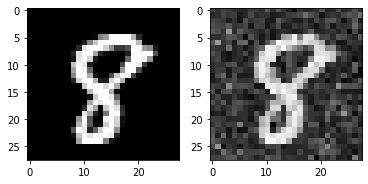

25  :  -0.23071554956853918 25
50  :  -0.22849572072539293 25
75  :  -0.22243994496224567 25
100  :  -0.21999984609282391 25
125  :  -0.21262258354018454 25
150  :  -0.21164372541371235 25
175  :  -0.21103602891077194 25
200  :  -0.20771807832516825 25
225  :  -0.20776257934687048 25
250  :  -0.2022915661329368 25
275  :  -0.20211529918248078 25
300  :  -0.2013421019057574 25
325  :  -0.2012880451050359 25
350  :  -0.20000616236840196 25
375  :  -0.194972463019847 25
400  :  -0.194972463019847 25
425  :  -0.194972463019847 25
450  :  -0.194972463019847 25
475  :  -0.19377776427438043 25
500  :  -0.1924909248254158 25
525  :  -0.1924909248254158 25
550  :  -0.19149340162582984 25
575  :  -0.19149340162582934 25
600  :  -0.19129512015528805 25
625  :  -0.18989338548128848 25
650  :  -0.18939963428676243 25
675  :  -0.1893752616084612 25
700  :  -0.1887068624273992 25
725  :  -0.18858478664324846 25
750  :  -0.1881758641960627 25
775  :  -0.18801099664645254 25
800  :  -0.1878912985107640

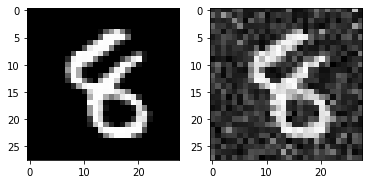

25  :  -0.2294243100285202 25
50  :  -0.2219694712962385 25
75  :  -0.21573465955968618 25
100  :  -0.2123739800549455 25
125  :  -0.2079209315207376 25
150  :  -0.2071328514048814 25
175  :  -0.20350704930848856 25
200  :  -0.20347844355591327 25
225  :  -0.20335146858915815 25
250  :  -0.19959743830311477 25
275  :  -0.19959743830311477 25
300  :  -0.1969512168034558 25
325  :  -0.19561089762913653 25
350  :  -0.1941774115647586 25
375  :  -0.1927537970409126 25
400  :  -0.1927537970409126 25
425  :  -0.1927537970409126 25
450  :  -0.19197871830224889 25
475  :  -0.19134600448033523 25
500  :  -0.1906928744699985 25
525  :  -0.19024161211494478 25
550  :  -0.1894607896174335 25
575  :  -0.18940770918505967 25
600  :  -0.18866561301638451 25
625  :  -0.18866561301638451 25
650  :  -0.18801872934706015 25
675  :  -0.1878651249140605 25
700  :  -0.18668828565664297 25
725  :  -0.18668828565664297 25
750  :  -0.18655911848370393 25
775  :  -0.18647432200045966 25
800  :  -0.1862369209166

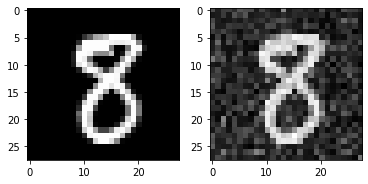

25  :  -0.2550204752447839 25
50  :  -0.25401488450999765 25
75  :  -0.2427680985466748 25
100  :  -0.24290678660704107 25
125  :  -0.24000615770734834 25
150  :  -0.23990952640580182 25
175  :  -0.23177934245186188 25
200  :  -0.22911773826484677 25
225  :  -0.22911773826484677 25
250  :  -0.22691286328303917 25
275  :  -0.22135808148036895 25
300  :  -0.22133501091088625 25
325  :  -0.22133501091088625 25
350  :  -0.22133501091088625 25
375  :  -0.22133501091088625 25
400  :  -0.22133501091088625 25
425  :  -0.22133501091088625 25
450  :  -0.22005985780412107 25
475  :  -0.22005985780412107 25
500  :  -0.22005985780412107 25
525  :  -0.22005985780412107 25
550  :  -0.2192673841618541 25
575  :  -0.2188958266400614 25
600  :  -0.21829977181895893 25
625  :  -0.21830260452220945 25
650  :  -0.2180551451152422 25
675  :  -0.21780757513224958 25
700  :  -0.2167768878828758 25
725  :  -0.21569518551747996 25
750  :  -0.21569532616450976 25
775  :  -0.21505889366094783 25
800  :  -0.215058

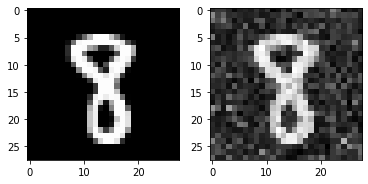

25  :  0.3709903748900778 25
50  :  0.5541573047270861 25
75  :  0.7038851293804688 25
100  :  0.7185870470840583 25
125  :  0.7122256671650042 25
150  :  0.7122256671650042 25
175  :  0.7122256671650042 25
200  :  0.7122256671650042 25
225  :  0.7122256671650042 25
250  :  0.7122256671650042 25
275  :  0.7133812831946563 25
300  :  0.7223271819335211 25
325  :  0.730517348389773 25
350  :  0.7290582719644685 25
375  :  0.7398137485351637 25
400  :  0.7358654024825894 25
425  :  0.7427987350394494 25
450  :  0.7389631307440163 25
475  :  0.7374746291455333 25
500  :  0.7459231643578442 25
525  :  0.7492606376671953 25
550  :  0.7492606376671953 25
575  :  0.7558076683042771 25
600  :  0.7492606376671953 25
625  :  0.7492606376671953 25
650  :  0.7492606376671953 25
675  :  0.7492606376671953 25
700  :  0.7492606376671953 25
725  :  0.752522979065843 25
750  :  0.752522979065843 25
775  :  0.752522979065843 25
800  :  0.752522979065843 25
825  :  0.7530431897282315 25
850  :  0.75273680

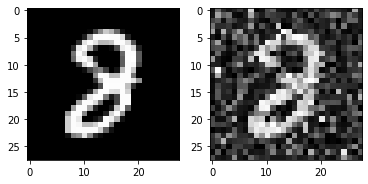

25  :  -0.17708178279220688 25
50  :  -0.16800066222692495 25
75  :  -0.15576868282812217 25
100  :  -0.1539976645099453 25
125  :  -0.14434250832928708 25
150  :  -0.14434250832928708 25
175  :  -0.1435199777644356 25
200  :  -0.1435468663578035 25
225  :  -0.14038397447022966 25
250  :  -0.13962496914275352 25
275  :  -0.13962496914275352 25
300  :  -0.1376837415058944 25
325  :  -0.13782873458968387 25
350  :  -0.13782873458968387 25
375  :  -0.13782873458968387 25
400  :  -0.1347118022550623 25
425  :  -0.1344483283596759 25
450  :  -0.13387707864557674 25
475  :  -0.13370287464438685 25
500  :  -0.13358638186297317 25
525  :  -0.1320534945073678 25
550  :  -0.13110571135983318 25
575  :  -0.13038497343905098 25
600  :  -0.13025390679558685 25
625  :  -0.1291414786020969 25
650  :  -0.1287198394821265 25
675  :  -0.1287198394821265 25
700  :  -0.1282334088316246 25
725  :  -0.12789550742212824 25
750  :  -0.127602270226792 25
775  :  -0.12757402805887785 25
800  :  -0.1273844551248

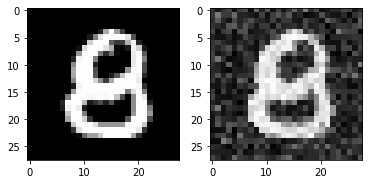

25  :  -0.2170012745112157 25
50  :  -0.21276100466650238 25
75  :  -0.20794135963327742 25
100  :  -0.20241249343538714 25
125  :  -0.20206642526892804 25
150  :  -0.2007153297579266 25
175  :  -0.19306228392935754 25
200  :  -0.19300652035951266 25
225  :  -0.18683259968015564 25
250  :  -0.1868861815664718 25
275  :  -0.1868861815664718 25
300  :  -0.18573187405157238 25
325  :  -0.182660385755683 25
350  :  -0.18236164308652858 25
375  :  -0.18237209721637448 25
400  :  -0.18163770221991232 25
425  :  -0.18163695530619928 25
450  :  -0.17916574098127763 25
475  :  -0.1788041193196614 25
500  :  -0.17880643942717317 25
525  :  -0.17880643942717317 25
550  :  -0.17833507819685668 25
575  :  -0.1778647609388011 25
600  :  -0.1771452909043219 25
625  :  -0.1767271488984935 25
650  :  -0.17570833955845538 25
675  :  -0.1754455490794285 25
700  :  -0.174551601925599 25
725  :  -0.17451405244943774 25
750  :  -0.17402828106243995 25
775  :  -0.17355459196476458 25
800  :  -0.1733525499560

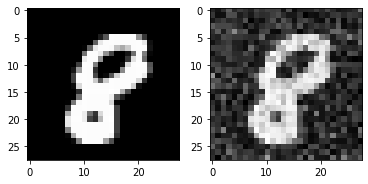

25  :  -0.22712836364742256 25
50  :  -0.21716465397093399 25
75  :  -0.21608463699229902 25
100  :  -0.21261474773496092 25
125  :  -0.19963080561443058 25
150  :  -0.19821296178479703 25
175  :  -0.1978833932170207 25
200  :  -0.1978907632326079 25
225  :  -0.19511181331702798 25
250  :  -0.19393277611899484 25
275  :  -0.19394226244230234 25
300  :  -0.1938987238858853 25
325  :  -0.19085672652723634 25
350  :  -0.19085672652723634 25
375  :  -0.19085672652723634 25
400  :  -0.19075553013335222 25
425  :  -0.1883269281863037 25
450  :  -0.18811768069613155 25
475  :  -0.1881181618112227 25
500  :  -0.18665628498871495 25
525  :  -0.18665628498871495 25
550  :  -0.18665628498871495 25
575  :  -0.186603284473011 25
600  :  -0.18606854764695846 25
625  :  -0.18606580192059258 25
650  :  -0.18568751777339776 25
675  :  -0.18568721186476694 25
700  :  -0.1853925150757214 25
725  :  -0.1838968302304002 25
750  :  -0.18389610603157003 25
775  :  -0.18389610603157003 25
800  :  -0.183896106

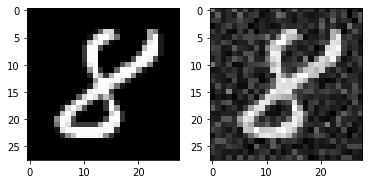

25  :  -0.2452065988016559 25
50  :  -0.24093438782958165 25
75  :  -0.23812509672633342 25
100  :  -0.2295317682054071 25
125  :  -0.2254292921444549 25
150  :  -0.2254380199008526 25
175  :  -0.22223456857266866 25
200  :  -0.22187898290559732 25
225  :  -0.21732399386348494 25
250  :  -0.21732399386348494 25
275  :  -0.21732399386348494 25
300  :  -0.21546927662927007 25
325  :  -0.215473269986186 25
350  :  -0.2124489036067077 25
375  :  -0.21171439197787456 25
400  :  -0.21026048256590646 25
425  :  -0.2093169489331989 25
450  :  -0.2086670975497606 25
475  :  -0.20866761381258903 25
500  :  -0.20866761381258903 25
525  :  -0.20818700415524538 25
550  :  -0.20750554960240997 25
575  :  -0.20683657820839518 25
600  :  -0.20644030861834473 25
625  :  -0.2064405368417201 25
650  :  -0.2064405368417201 25
675  :  -0.20538028360930727 25
700  :  -0.20538028360930727 25
725  :  -0.20522252076312952 25
750  :  -0.20522281555885863 25
775  :  -0.20505220635207705 25
800  :  -0.20433024984

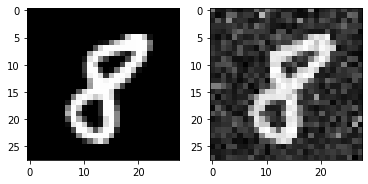

25  :  0.7075206263494267 25
50  :  0.7075206263494267 25
75  :  0.7175786685150648 25
100  :  0.7164296612914576 25
125  :  0.7164296612914576 25
150  :  0.723595727339153 25
175  :  0.7272118533069016 25
200  :  0.7254609494982646 25
225  :  0.7254609494982646 25
250  :  0.7293411717134437 25
275  :  0.7290775908790207 25
300  :  0.7296893685879755 25
325  :  0.7296893685879755 25
350  :  0.734173459517543 25
375  :  0.7340544637099404 25
400  :  0.7340544637099404 25
425  :  0.7340544637099404 25
450  :  0.7340544637099404 25
475  :  0.7342785062765048 25
500  :  0.7347899628062246 25
525  :  0.7347899628062246 25
550  :  0.7347899628062246 25
575  :  0.7364902314932351 25
600  :  0.7405301003118415 25
625  :  0.7427151630190276 25
650  :  0.742499294887061 25
675  :  0.7425741281006749 25
700  :  0.7439182509443731 25
725  :  0.74392216168619 25
750  :  0.74392216168619 25
775  :  0.7472263353919595 25
800  :  0.7475502517775946 25
825  :  0.7502494561434201 25
850  :  0.7502419858

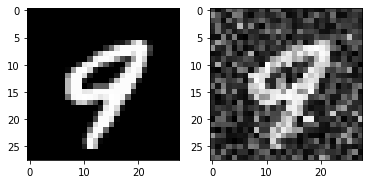

25  :  0.6963522607105704 25
50  :  0.725814281660389 25
75  :  0.726093111370567 25
100  :  0.7283752772098013 25
125  :  0.7283752772098013 25
150  :  0.7283752772098013 25
175  :  0.7283752772098013 25
200  :  0.7283752772098013 25
225  :  0.7283752772098013 25
250  :  0.7283752772098013 25
275  :  0.7283752772098013 25
300  :  0.7313646041922403 25
325  :  0.7318111036381283 25
350  :  0.7318205303174161 25
375  :  0.7318205303174161 25
400  :  0.735203161545894 25
425  :  0.735065781981564 25
450  :  0.735065781981564 25
475  :  0.735065781981564 25
500  :  0.735065781981564 25
525  :  0.7360590628169066 25
550  :  0.7360590628169066 25
575  :  0.7389249736246499 25
600  :  0.7385609163168139 25
625  :  0.7385609163168139 25
650  :  0.7413096078315012 25
675  :  0.7422337654274862 25
700  :  0.7421448966515612 25
725  :  0.7421448966515612 25
750  :  0.7450891946070792 25
775  :  0.7451268694281218 25
800  :  0.7451268694281218 25
825  :  0.7453675009999812 25
Time:  46.0662415027

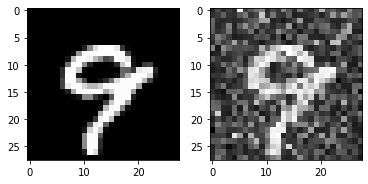

25  :  0.7041658008202366 25
50  :  0.7041658008202366 25
75  :  0.7041658008202366 25
100  :  0.7044116568470977 25
125  :  0.7062312395926886 25
150  :  0.7052743180605666 25
175  :  0.7052743180605666 25
200  :  0.7052743180605666 25
225  :  0.7092193568490769 25
250  :  0.7103393884887056 25
275  :  0.7100281972804187 25
300  :  0.7129033747291754 25
325  :  0.7129033747291754 25
350  :  0.7129033747291754 25
375  :  0.7163423063284473 25
400  :  0.7162578397937414 25
425  :  0.7162578397937414 25
450  :  0.7200333560758393 25
475  :  0.7197763796427308 25
500  :  0.7197763796427308 25
525  :  0.7197763796427308 25
550  :  0.7201564033943949 25
575  :  0.7201564033943949 25
600  :  0.7208160476375234 25
625  :  0.720654838345292 25
650  :  0.7235111691800706 25
675  :  0.7269637910620483 25
700  :  0.7269637910620483 25
725  :  0.7269637910620483 25
750  :  0.7271899009370364 25
775  :  0.7270311901782001 25
800  :  0.728576877182324 25
Time:  44.64745283126831  seconds
Predicted c

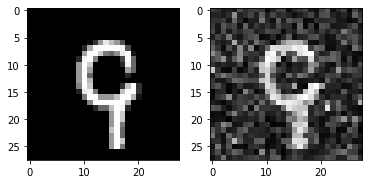

25  :  0.7307113357815099 25
50  :  0.7333943336681727 25
75  :  0.7365409393044351 25
100  :  0.7338440771975353 25
125  :  0.7338440771975353 25
150  :  0.7338440771975353 25
175  :  0.7338440771975353 25
200  :  0.7338440771975353 25
225  :  0.7342882027092892 25
250  :  0.7342882027092892 25
275  :  0.7342882027092892 25
300  :  0.7368148107406549 25
325  :  0.7368148107406549 25
350  :  0.7417173266795235 25
375  :  0.7435991289684705 25
400  :  0.7440931884906697 25
425  :  0.7448695804129156 25
450  :  0.7513431960027885 25
475  :  0.7513431960027885 25
500  :  0.7513431960027885 25
525  :  0.7552294464080321 25
550  :  0.7552294464080321 25
575  :  0.7552294464080321 25
600  :  0.7552294464080321 25
625  :  0.7564066085019783 25
650  :  0.7562939301242777 25
675  :  0.7571749541965912 25
700  :  0.7569864857502494 25
725  :  0.7577897456993309 25
750  :  0.7596136299655543 25
775  :  0.7595981763864456 25
800  :  0.7599545858282262 25
Time:  45.09045338630676  seconds
Predicted

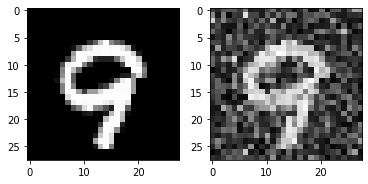

25  :  0.7151825426547594 25
50  :  0.7151825426547594 25
75  :  0.7354217879178766 25
100  :  0.7354217879178766 25
125  :  0.7464459322118921 25
150  :  0.7425532209069408 25
175  :  0.7425532209069408 25
200  :  0.7425532209069408 25
225  :  0.7425532209069408 25
250  :  0.7425532209069408 25
275  :  0.7425532209069408 25
300  :  0.7452889272793364 25
325  :  0.747537277263828 25
350  :  0.7491132307952376 25
375  :  0.751355420951775 25
400  :  0.7525384103860874 25
425  :  0.7531871838660278 25
450  :  0.7552674099199375 25
475  :  0.7571013843830217 25
500  :  0.7571013843830217 25
525  :  0.7571013843830217 25
550  :  0.7571013843830217 25
575  :  0.7571876694105506 25
600  :  0.7575412810578528 25
625  :  0.7582167753153175 25
650  :  0.7585913033211397 25
675  :  0.7595715459937169 25
700  :  0.7614429976277747 25
725  :  0.7614419926701768 25
750  :  0.7614419926701768 25
775  :  0.7614419926701768 25
800  :  0.7623089155352787 25
825  :  0.7623175623453626 25
850  :  0.76231

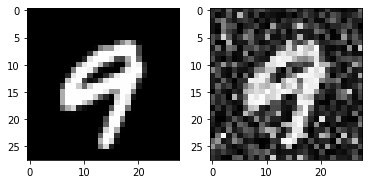

25  :  0.7066217343907248 25
50  :  0.7110043315954017 25
75  :  0.7110105069454384 25
100  :  0.7119523569053622 25
125  :  0.7121635896676674 25
150  :  0.7215500734425717 25
175  :  0.721927010900097 25
200  :  0.7215792852408507 25
225  :  0.7215792852408507 25
250  :  0.722133195578619 25
275  :  0.7241154188546224 25
300  :  0.7265693962436044 25
325  :  0.7263870419144316 25
350  :  0.7280463789144951 25
375  :  0.7282109346643668 25
400  :  0.7280049268536278 25
425  :  0.7292603132243705 25
450  :  0.7292022205193728 25
475  :  0.7308646973289847 25
500  :  0.7320301741981032 25
525  :  0.7328117814623988 25
550  :  0.732454611237053 25
575  :  0.7326029112743295 25
600  :  0.7345209549314466 25
625  :  0.7345182803216403 25
650  :  0.7349182926504635 25
675  :  0.735030732155436 25
700  :  0.7355440232478262 25
725  :  0.7373990135730683 25
750  :  0.7373990135730683 25
775  :  0.7376840879535442 25
800  :  0.7390484843168901 25
Time:  44.82317566871643  seconds
Predicted cla

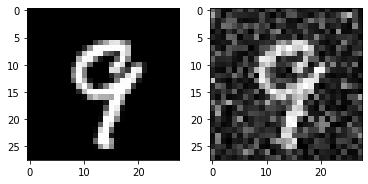

25  :  0.6959006518851288 25
50  :  0.6959006518851288 25
75  :  0.6948954701301432 25
100  :  0.6948954701301432 25
125  :  0.6948954701301432 25
150  :  0.7002061187592258 25
175  :  0.7002061187592258 25
200  :  0.7002061187592258 25
225  :  0.7042627120545792 25
250  :  0.703623418145614 25
275  :  0.703623418145614 25
300  :  0.703623418145614 25
325  :  0.703623418145614 25
350  :  0.703623418145614 25
375  :  0.703623418145614 25
400  :  0.703623418145614 25
425  :  0.7042718244559867 25
450  :  0.7042718244559867 25
475  :  0.7042718244559867 25
500  :  0.7042718244559867 25
525  :  0.7086250316694415 25
550  :  0.7086250316694415 25
575  :  0.7086250316694415 25
600  :  0.7086250316694415 25
625  :  0.7086250316694415 25
650  :  0.7086250316694415 25
675  :  0.7095213187654694 25
700  :  0.7116096650931081 25
725  :  0.711917867012797 25
750  :  0.7121497903116244 25
775  :  0.7128910043580104 25
800  :  0.7128910043580104 25
Time:  45.10648274421692  seconds
Predicted class: 

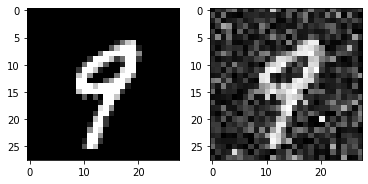

25  :  0.6858701682610464 25
50  :  0.6858701682610464 25
75  :  0.6882020651035698 25
100  :  0.6873324237901381 25
125  :  0.6875953772961307 25
150  :  0.6873324237901381 25
175  :  0.6873324237901381 25
200  :  0.6873324237901381 25
225  :  0.6873324237901381 25
250  :  0.6885113498068337 25
275  :  0.6973770952406089 25
300  :  0.6973770952406089 25
325  :  0.6973770952406089 25
350  :  0.699617679496453 25
375  :  0.699617679496453 25
400  :  0.699617679496453 25
425  :  0.699617679496453 25
450  :  0.699617679496453 25
475  :  0.699617679496453 25
500  :  0.699617679496453 25
525  :  0.7001951194586145 25
550  :  0.7001951194586145 25
575  :  0.7001951194586145 25
600  :  0.7009548602893648 25
625  :  0.7014893363584214 25
650  :  0.7042461917440368 25
675  :  0.7042461917440368 25
700  :  0.7042461917440368 25
725  :  0.7054684873480098 25
750  :  0.706026307095766 25
775  :  0.7070599647981031 25
800  :  0.7071855616659226 25
Time:  44.63991689682007  seconds
Predicted class: 

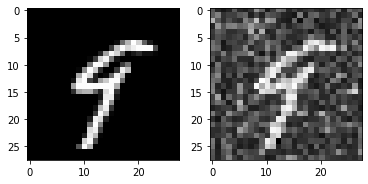

25  :  0.699877922623292 25
50  :  0.699877922623292 25
75  :  0.7157240116419498 25
100  :  0.705757218355094 25
125  :  0.705757218355094 25
150  :  0.705757218355094 25
175  :  0.705757218355094 25
200  :  0.705757218355094 25
225  :  0.7091862974190485 25
250  :  0.7088970595148752 25
275  :  0.7096839507608437 25
300  :  0.7093114172403687 25
325  :  0.7125084998778614 25
350  :  0.7137345520785717 25
375  :  0.7134504145002962 25
400  :  0.7134504145002962 25
425  :  0.7169649669623179 25
450  :  0.7168454565781333 25
475  :  0.7180115575194008 25
500  :  0.7199944796149018 25
525  :  0.7199678813985221 25
550  :  0.7199678813985221 25
575  :  0.7199678813985221 25
600  :  0.7199678813985221 25
625  :  0.7199678813985221 25
650  :  0.7199678813985221 25
675  :  0.7209015535601864 25
700  :  0.7224320102987223 25
725  :  0.7224111838567963 25
750  :  0.7230388174806948 25
775  :  0.7237256524988078 25
800  :  0.7245203803951269 25
825  :  0.7245124817234424 25
850  :  0.7245314271

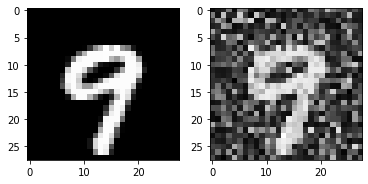

25  :  0.6796692224003906 25
50  :  0.6796692224003906 25
75  :  0.6796692224003906 25
100  :  0.6796692224003906 25
125  :  0.6886323568431689 25
150  :  0.6890844296058206 25
175  :  0.6890844296058206 25
200  :  0.6890844296058206 25
225  :  0.6908172782512937 25
250  :  0.6926049705666578 25
275  :  0.6926735145989442 25
300  :  0.6935530273967592 25
325  :  0.6959761398607303 25
350  :  0.6951787130244733 25
375  :  0.6951787130244733 25
400  :  0.6981098938219313 25
425  :  0.6982186332298949 25
450  :  0.6991994329151481 25
475  :  0.6987793409288652 25
500  :  0.6990077112818562 25
525  :  0.700290248105288 25
550  :  0.7028460483651293 25
575  :  0.703696798655646 25
600  :  0.703710237377644 25
625  :  0.703710237377644 25
650  :  0.7042299687120053 25
675  :  0.7048627823997073 25
700  :  0.7052252336061 25
725  :  0.7052279938550222 25
750  :  0.7052279938550222 25
775  :  0.7062541048273785 25
800  :  0.7062541048273785 25
Time:  44.72167992591858  seconds
Predicted class:

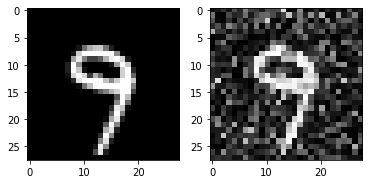

25  :  0.7438062058650428 25
50  :  0.7438062058650428 25
75  :  0.7438110581367531 25
100  :  0.746845947532597 25
125  :  0.746845947532597 25
150  :  0.7472191060108215 25
175  :  0.7472191060108215 25
200  :  0.7525897599998937 25
225  :  0.7525897599998937 25
250  :  0.7559310749350676 25
275  :  0.755065813124 25
300  :  0.755065813124 25
325  :  0.755065813124 25
350  :  0.755065813124 25
375  :  0.755149027492344 25
400  :  0.7552520353382195 25
425  :  0.7559292866394931 25
450  :  0.755795998435385 25
475  :  0.755795998435385 25
500  :  0.7562490484170945 25
525  :  0.7561063666691634 25
550  :  0.7570284722285381 25
575  :  0.7591694906037776 25
600  :  0.7590422634144198 25
625  :  0.7590422634144198 25
650  :  0.7590422634144198 25
675  :  0.7590422634144198 25
700  :  0.7590422634144198 25
725  :  0.760354876459258 25
750  :  0.7627571863264295 25
775  :  0.7627571863264295 25
800  :  0.7643446352892715 25
Time:  44.87754845619202  seconds
Predicted class:  [8]


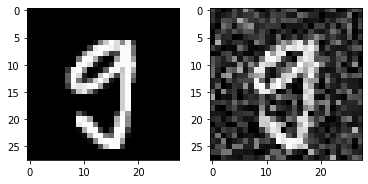

25  :  0.7054363377149903 25
50  :  0.7063222640095314 25
75  :  0.7059665827470246 25
100  :  0.7068059074781606 25
125  :  0.7068059074781606 25
150  :  0.7068059074781606 25
175  :  0.7068059074781606 25
200  :  0.7068059074781606 25
225  :  0.7121738837066334 25
250  :  0.7142674649862581 25
275  :  0.7142674649862581 25
300  :  0.7142674649862581 25
325  :  0.7142674649862581 25
350  :  0.7148404816328883 25
375  :  0.7147678632070364 25
400  :  0.7148556050356889 25
425  :  0.7179367560254393 25
450  :  0.7192657298394707 25
475  :  0.7226924967333492 25
500  :  0.7226101052489666 25
525  :  0.7247002782215685 25
550  :  0.7271346273210386 25
575  :  0.7276270149594878 25
600  :  0.7283064293383033 25
625  :  0.7283202604360307 25
650  :  0.7297792166823941 25
675  :  0.7301749002275751 25
700  :  0.7300491079535688 25
725  :  0.7302661146135098 25
750  :  0.7311220245404815 25
775  :  0.7311852202365099 25
800  :  0.7319175476965081 25
Time:  44.973047494888306  seconds
Predicte

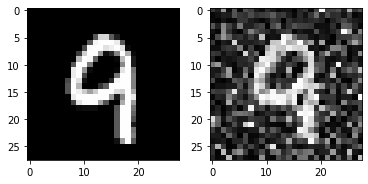

25  :  0.7340283194302348 25
50  :  0.7412064869896884 25
75  :  0.7344890837766356 25
100  :  0.7340475011249357 25
125  :  0.7430538351427094 25
150  :  0.7433307911655702 25
175  :  0.7433307911655702 25
200  :  0.7433307911655702 25
225  :  0.7433307911655702 25
250  :  0.7433307911655702 25
275  :  0.7433307911655702 25
300  :  0.7477204823021926 25
325  :  0.7477204823021926 25
350  :  0.7477204823021926 25
375  :  0.7477204823021926 25
400  :  0.7477204823021926 25
425  :  0.7477204823021926 25
450  :  0.7477204823021926 25
475  :  0.7492197683470359 25
500  :  0.7495543754639951 25
525  :  0.7495543754639951 25
550  :  0.7495543754639951 25
575  :  0.7495543754639951 25
600  :  0.7527508317656952 25
625  :  0.7529635187755236 25
650  :  0.7529635187755236 25
675  :  0.7529635187755236 25
700  :  0.7529635187755236 25
725  :  0.7570810719214114 25
750  :  0.7583485221493509 25
775  :  0.7599455197125352 25
800  :  0.759776574383344 25
Time:  44.709144830703735  seconds
Predicted

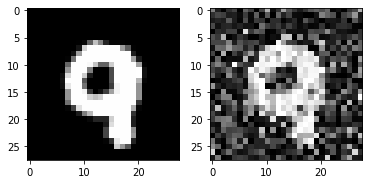

In [8]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28,28,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_cnn_mnist_ssim_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [10]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

71.04118394851685
44.30660367012024
48.16045852123745
4.743248282097244


In [11]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1175
800
846.6269841269841
77.62299345636401


In [12]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

14.878765891252472
9.515197248408203
12.064202362320822
1.3094640532504394
